# Numerical Variable Analysis

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from os.path import isfile
from tqdm import tqdm
import re

## Removing Duplicates

In [2]:
def clean_data_columns(dataframe):
    dataframe_corrected = dataframe.drop(columns=[x for x in dataframe.columns if 'k_user' in x])

    dataframe_corrected = dataframe_corrected.rename(columns={"predictedValue": "point_value",
                                                              "Metric:": "metric",
                                                              "Case:": "case",
                                                              "Depth:": "depth",
                                                              "Energy:": "energy",
                                                              "Energy_FFF :": "energy_fff",
                                                              "Gantry:": "gantry",
                                                              "Mode:": "mode",
                                                              "Au date": "date",
                                                              "Point type": "point_type"})

    columns_to_keep = [x for x in dataframe_corrected.columns if "k_user" not in x]
    dataframe_corrected = dataframe_corrected[columns_to_keep]

    dataframe_corrected = dataframe_corrected[
        dataframe_corrected['point_type'].isin(['Prescription Point', 'Worst Point +ve', 'Worst Point -ve'])]
    dataframe_corrected = dataframe_corrected[dataframe_corrected['case'].isin(cases)]
    dataframe_corrected.columns = [x.lower() for x in dataframe_corrected.columns]

    missing_date = dataframe_corrected.iloc[11571]['date']
    dataframe_corrected["date"].fillna(missing_date, inplace=True)

    dataframe_corrected = dataframe_corrected[dataframe_corrected['manuf'] != "Wavy Welsh Corgi"]

    return dataframe_corrected

In [3]:
def remove_duplicates(dataframe):
    """
    Cascade all the updated values onto the old values
    For predicted_id "467035_2_PxVar|2|10|6|0|0|1" in dataframe, finds predicted_id ""467035_1_PxVar|2|10|6|0|0|1"" in
    and replaces the point_value of the main dataframe with those from updated_dataframe
    :param dataframe: Dataframe that contains all the data
    :return: Updated dataframe without any duplicate values
    """

    def convert_date(x):
        x = str(x)

        date_format = "%Y-%m-%d"
        return datetime.strptime(x, date_format)

    dataframe_main = dataframe[dataframe['new_audit_id'].apply(lambda x: True if int(x[-1]) == 1 else False)].reset_index(drop=True)
    dataframe_updates = dataframe[dataframe['new_audit_id'].apply(lambda x: True if int(x[-1]) != 1 else False)].reset_index(drop=True)

    # id_remove_main = []
    id_remove_update = []

    print("Preliminary diagnostics")
    print(f"main_dataframe shape: {dataframe_main.shape}")
    print(f"updated_dataframe shape: {dataframe_updates.shape}", end="\n\n")

    for index, row in tqdm(dataframe_main.iterrows()):

        main_date = convert_date(row['date'])

        predicted_id_2 = re.sub(r"_(\d)_", "_2_", row['predicted_id'])
        predicted_id_3 = re.sub(r"_(\d)_", "_3_", row['predicted_id'])
        predicted_id_4 = re.sub(r"_(\d)_", "_4_", row['predicted_id'])

        row_revised_2 = dataframe_updates.loc[dataframe_updates["predicted_id"] == predicted_id_2]
        row_revised_3 = dataframe_updates.loc[dataframe_updates["predicted_id"] == predicted_id_3]
        row_revised_4 = dataframe_updates.loc[dataframe_updates["predicted_id"] == predicted_id_4]

        # Drop from updates
        if len(row_revised_2) != 0:
            revised_2_date = convert_date(row_revised_2['date'].iloc[0])
            if (revised_2_date - main_date).days < 365:
                id_remove_update.append(row_revised_2.index[0])

        if len(row_revised_3) != 0:
            revised_3_date = convert_date(row_revised_3['date'].iloc[0])
            if (revised_3_date - main_date).days < 365:
                id_remove_update.append(row_revised_3.index[0])

        if len(row_revised_4) != 0:
            revised_4_date = convert_date(row_revised_4['date'].iloc[0])
            if (revised_4_date - main_date).days < 365:
                id_remove_update.append(row_revised_4.index[0])

        # Add new to main and drop original from main
        if len(row_revised_4) != 0:
            if (revised_4_date - main_date).days < 365:
                dataframe_main.loc[index, 'point_value'] = row_revised_4['point_value'].iloc[0]
                dataframe_main.loc[index, 'predicted_id'] = row_revised_4['predicted_id'].iloc[0]
                # id_remove_main.append(index)

        elif len(row_revised_3) != 0:
            if (revised_3_date - main_date).days < 365:
                dataframe_main.loc[index, 'point_value'] = row_revised_3['point_value'].iloc[0]
                dataframe_main.loc[index, 'predicted_id'] = row_revised_3['predicted_id'].iloc[0]
                # id_remove_main.append(index)
        elif len(row_revised_2) != 0:
            if (revised_2_date - main_date).days < 365:
                dataframe_main.loc[index, 'point_value'] = row_revised_2['point_value'].iloc[0]
                dataframe_main.loc[index, 'predicted_id'] = row_revised_2['predicted_id'].iloc[0]
                # id_remove_main.append(index)

    main_updated = dataframe_main
    updates_updated = dataframe_updates.drop(id_remove_update)
    dataframe_merged = pd.concat([main_updated, updates_updated], axis=0)

    print("\nConcluding diagnostics")
    print(f"main_updated shape: {main_updated.shape}")
    print(f"updated_dataframe shape: {updates_updated.shape}")
    print(f"dataframe_merged shape: {dataframe_merged.shape}", end="\n\n")

    return dataframe_merged

In [4]:
cases = [2, 3, 6, 7, 8, 9, 10]

In [5]:
df = pd.read_csv("Cleansing the data/Clean_data.csv", low_memory=False)
data = clean_data_columns(df)
data_no_duplicates = remove_duplicates(data)

Preliminary diagnostics
main_dataframe shape: (11510, 44)
updated_dataframe shape: (6178, 44)



11510it [00:16, 693.34it/s]


Concluding diagnostics
main_updated shape: (11510, 44)
updated_dataframe shape: (404, 44)
dataframe_merged shape: (11914, 44)



# Creating datasets per case

In [107]:
def create_per_case_datafiles(dataframe):
    for case in cases:
        temp_df = dataframe[dataframe["case"] == case].reset_index(drop=True)
        
        excel_file_name = "Cleansing the data\Datasets by Case\Excel\case_" + str(case) + ".xlsx"
        csv_file_name = "Cleansing the data\Datasets by Case\CSV\case_" + str(case) + ".csv"

        temp_df.to_excel(excel_file_name, index=False)
        temp_df.to_csv(csv_file_name, index=False)

In [13]:
create_per_case_datafiles(data_no_duplicates)

# Correcting for case 3

In [14]:
def add_corrected_point_value(reference_data, target_data):
    """
    Correcting point_values for ALL POINT TYPES, and ALL DEPTHS using corresponding prescription point value of case 3
    """

    # target_data["corrected_point_value"] = None
    current_case = target_data["case"].iloc[0]
    errors = False
    print(f"Correcting for case:{current_case}")
    
    for index, row in target_data.iterrows():
        current_id = row["audit_id"]
        current_point_type = row["point_type"]
        current_energy = row["energy"]
        current_fff = row["energy_fff"]
        current_date = row["date"]
        current_point_value = row["point_value"]

        try:
            c3_reference_value = reference_data["point_value"][(reference_data["audit_id"] == current_id) &
                                                               (reference_data["point_type"] == "Prescription Point") &
                                                               (reference_data["energy"] == current_energy) &
                                                               (reference_data["energy_fff"] == current_fff) &
                                                               (reference_data["case"] == 3) &
                                                               (reference_data["depth"] == 10) &
                                                               (reference_data["date"] == current_date)].iloc[0]
        except IndexError:
            errors = True
            print(f"For audit_id {current_id}:")
            if current_id not in reference_data["audit_id"].values:
                print(f"{current_id} not in reference data")

            if current_point_type not in reference_data["point_type"]:
                print(f"{current_point_type} not in reference_data")

            if current_energy not in reference_data["energy"].values:
                print(f"Energy:{current_energy} not in reference data")

            if current_fff not in reference_data["energy_fff"].values:
                print(f"fff:{current_fff} not in reference data")

            if 10 not in reference_data["depth"].values:
                print(f"Depth 10 not in reference data")

            if current_date not in reference_data["date"].values:
                print(f"Date:{current_date} not in reference data")

            print("Error")
            continue

        corrected_point_value = ((current_point_value + 1) / (c3_reference_value + 1)) - 1
        target_data.loc[index, "corrected_point_value"] = corrected_point_value
    if not errors:
        print("No Errors")

    return target_data

In [49]:
def create_and_save_corrected_values():
    case3_data = pd.read_csv("Cleansing the data/Datasets by Case/CSV/case_3.csv") 
    merged_data = pd.DataFrame()

    for case in cases:
        csv_file_name = "Cleansing the data/Datasets by Case/CSV/case_" + str(case) + ".csv"
        casex_data = pd.read_csv(csv_file_name)

        corrected_data = add_corrected_point_value(case3_data, casex_data)
        corrected_data.to_csv(f"Cleansing the data/Datasets by Case/Case3_Corrected/case_{case}_corrected.csv", index=False)

        merged_data = pd.concat([merged_data, corrected_data], axis=0).reset_index(drop = True)

    merged_data.to_csv("Cleansing the data/FINAL_DATA.csv", index=False)
    return merged_data

In [50]:
final_data = create_and_save_corrected_values()

Correcting for case:2
No Errors
Correcting for case:3
No Errors
Correcting for case:6
No Errors
Correcting for case:7
No Errors
Correcting for case:8
No Errors
Correcting for case:9
No Errors
Correcting for case:10
No Errors


In [63]:
# CASES WHERE CORRECTED POINT VALUE IS NOT 0 FOR CASE 3
final_data[(final_data['corrected_point_value'] != 0)&
          (final_data['case'] == 3)&
          (final_data['depth'] == 10)&
          (final_data['point_type'] == "Prescription Point")]

,predicted_id,new_audit_id,audit_id,facility_id,status,auditor1,auditor2,auditor3,date,manuf,...,metric,case,depth,energy,energy_fff,gantry,mode,point_type,point_value,corrected_point_value
3787,634446_4_PxVar|3|10|6|1|0|1,634446_4,634446,Reasonable Guppy,NaN,Squeaky Anteater,Agitated Emperor Tamarin,NaN,2022-11-21,Self-assured Grey Seal,...,PxVar,3,10,6,1,0,1,Prescription Point,0.009,0.010010
3799,652624_4_PxVar|3|10|6|1|0|1,652624_4,652624,Immaterial Neapolitan Mastiff,NaN,Miserable Eastern Gorilla,Prickly Chinook,NaN,2022-11-15,Self-assured Grey Seal,...,PxVar,3,10,6,1,0,1,Prescription Point,0.000,0.010101


# Numerical Analysis

In [10]:
data = pd.read_csv("Cleansing the data/FINAL_DATA.csv", low_memory=False)
df = data[data["metric"]=="PxVar"]
df.dtypes.value_counts()

In [13]:
non_category_columns = [x for x in df.columns if df[x].dtypes != 'O']
# non_category_columns.remove('Au date')

date_column = [x for x in df.columns if df[x].dtypes == "datetime64[ns]"] 

columns_to_remove = [x for x in non_category_columns if df[x].value_counts().count() < 8]
columns_to_remove.remove('15_daily_output')
columns_to_remove.remove('15__tpr_20,10')
columns_to_remove.append('audit_id')
columns_to_remove.append('case')

numerical_columns = [x for x in non_category_columns if x not in columns_to_remove]
numerical_columns

['6_daily_output',
 '10_daily_output',
 '15_daily_output',
 '18_daily_output',
 '6fff_daily_output',
 '10fff_daily_output',
 '6__tpr_20,10',
 '10__tpr_20,10',
 '15__tpr_20,10',
 '18__tpr_20,10',
 '6fff__tpr_20,10',
 '10fff__tpr_20,10',
 'point_value',
 'corrected_point_value']

## Missing values in each column

In [68]:
missing_count = df[numerical_columns].isna().sum()
missing_count = missing_count.sort_values(ascending = False)

missing_percent = (df[numerical_columns].isna().sum() / df[numerical_columns].shape[0]) * 100
missing_percent = missing_percent.sort_values(ascending = False)

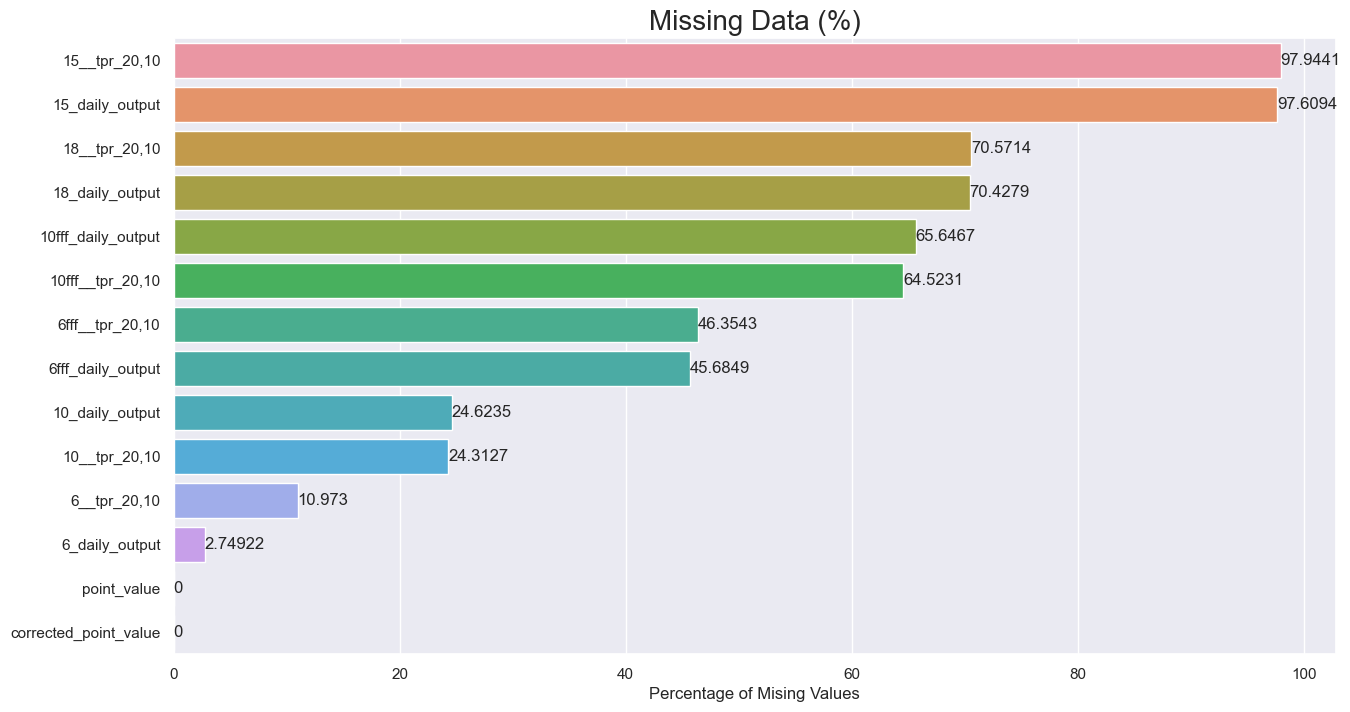

In [69]:
sns.set(rc={'figure.figsize':(15,8)})

ax = sns.barplot(y = missing_percent.index, x = missing_percent.values, orient='h')
ax.set(xlabel="Percentage of Mising Values", yticklabels=missing_percent.index)
ax.set_title("Missing Data (%)", size = 20)
sns.set_theme(style = "white")
for i in ax.containers:
    ax.bar_label(i,)

plt.savefig("Figures/Missing Data.png")
plt.show()

In [73]:
# # Columns with more than 35% missing values
numerical_columns =  [name for name, value in zip(missing_percent.index, missing_percent.values) if value <= 35]

In [74]:
numerical_columns.remove('point_value')

In [71]:
# print(f"Total number of features to be included in the numerical analysis: {len(numerical_columns)}\n")
# for col in df[numerical_columns].columns:
#     print(col)

## Distributions of each feature

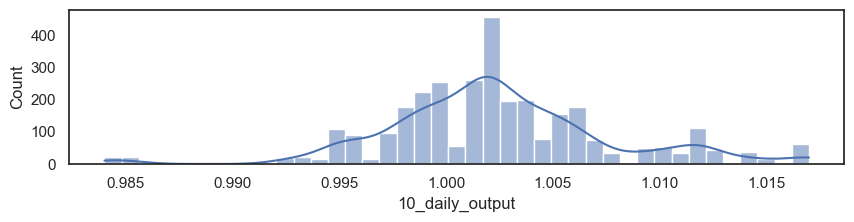

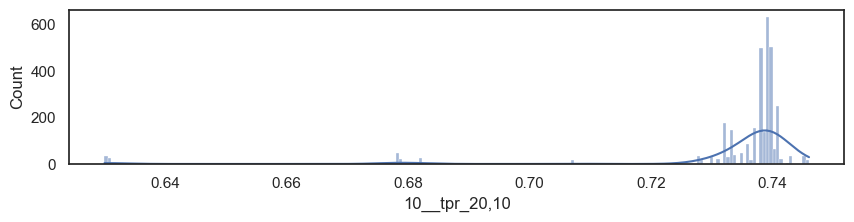

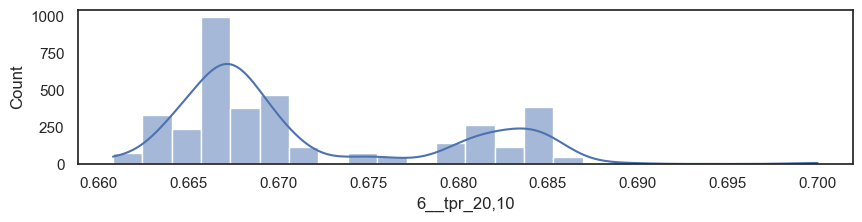

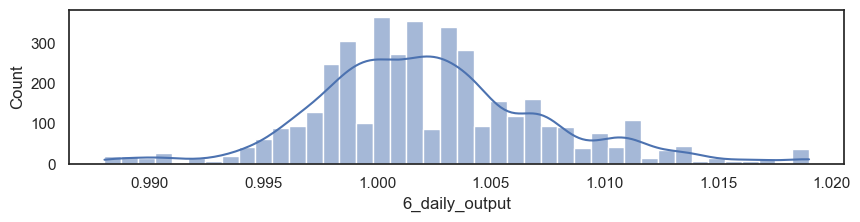

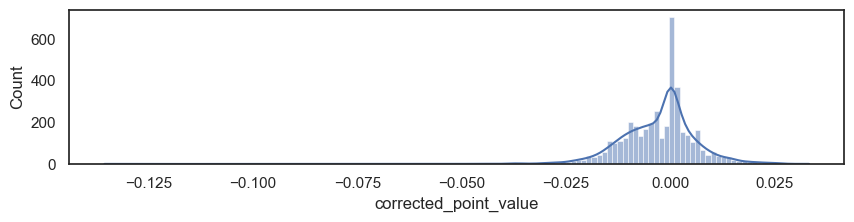

In [75]:
num_filled_cells = len(numerical_columns) #7
for i in range(num_filled_cells):
    sns.set(rc={'figure.figsize':(10,2)})
    sns.set_style("white")
    sns.histplot(df[numerical_columns[i]], color = "C0", kde = True)
    file_name = "Histogram--" + str(numerical_columns[i])
    plt.savefig("Figures/Histograms/"+file_name)
    plt.show()

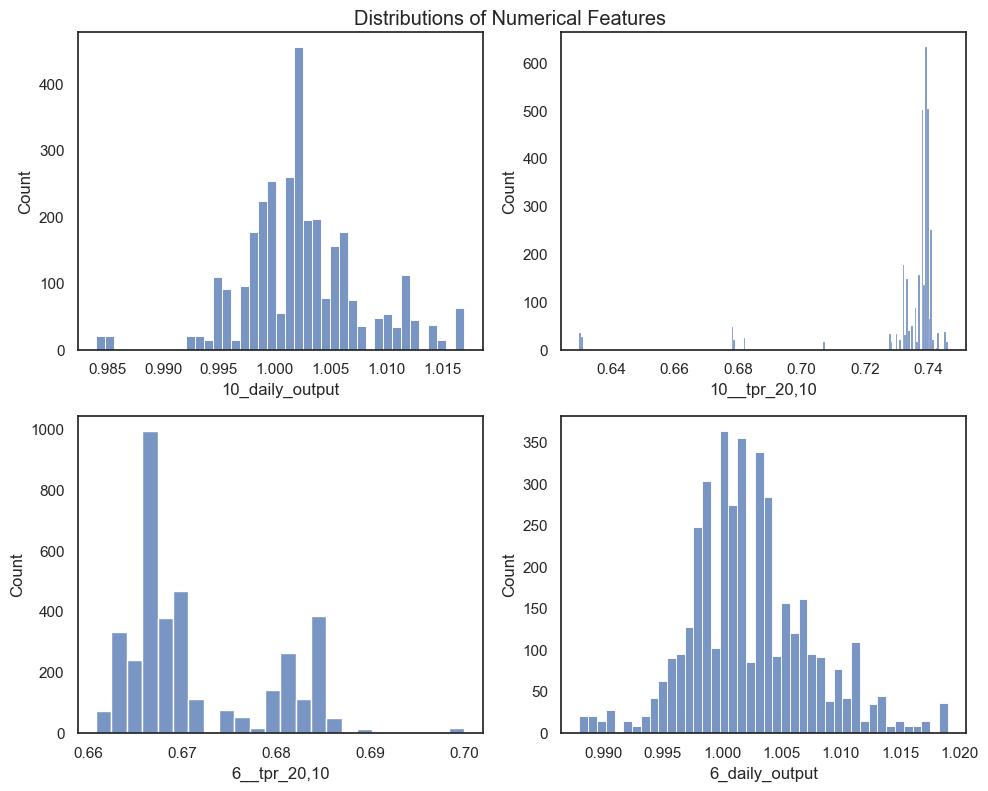

In [77]:
# rows = 7
# cols = 3

rows = 2
cols = 2
num_filled_cells = len(numerical_columns)-1 #7

fig, ax = plt.subplots(ncols = cols, nrows=rows, squeeze= False, figsize = (10,8))
fig.tight_layout(pad=2)
for i in range(num_filled_cells):
    row = i//cols
    col = i%cols
    sns.histplot(df[numerical_columns[i]], ax = ax[row, col], color = "C0")
    
fig.suptitle("Distributions of Numerical Features")
    
# ax[2,2].set_axis_off()
# ax[2,1].set_axis_off()

plt.savefig("Figures/Histograms/Distributions of Numerical Features.png")
plt.show()

## Ranges and Potential Outliers

In [79]:
cols = sns.color_palette("Spectral",8)
cols

[(0.8472126105344099, 0.2612072279892349, 0.30519031141868513),
 (0.9637831603229527, 0.47743175701653207, 0.28581314878892733),
 (0.9934640522875817, 0.7477124183006535, 0.4352941176470587),
 (0.9977700884275279, 0.930872741253364, 0.6330642060745867),
 (0.944252210688197, 0.9777008842752788, 0.6620530565167244),
 (0.7477124183006538, 0.8980392156862746, 0.6274509803921569),
 (0.4530565167243369, 0.7815455594002307, 0.6462898885044214),
 (0.21607074202229912, 0.5556324490580546, 0.7319492502883507)]

0
Boxplot--10_daily_output


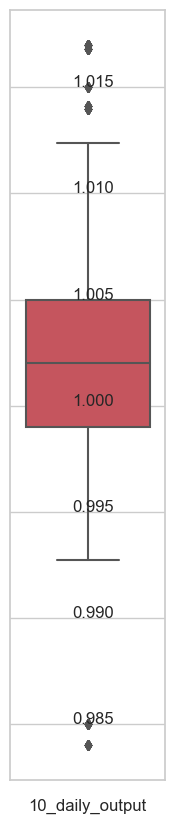

1
Boxplot--10__tpr_20,10


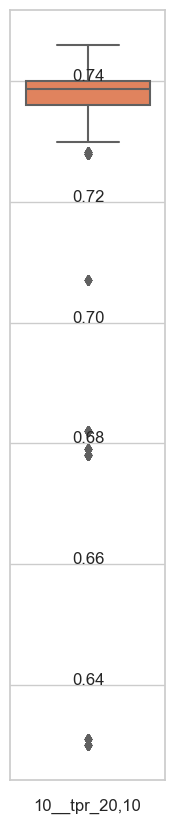

2
Boxplot--6__tpr_20,10


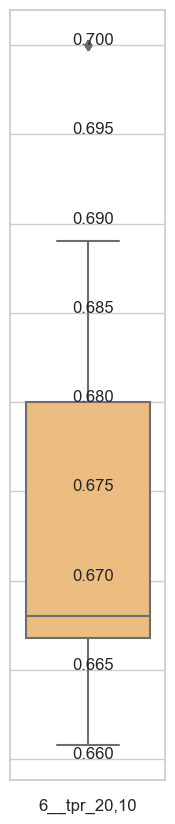

3
Boxplot--6_daily_output


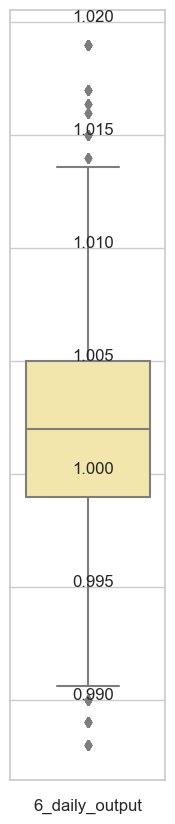

In [80]:
sns.set(rc={'figure.figsize':(2,10)})
sns.set_style("whitegrid")

for i in range(len(numerical_columns[:-1])):
    print(i)

    p = sns.boxplot(df[numerical_columns[i]], color=cols[i],orient='v')
    
    ylab_text = p.get_yticklabels()
                 
    ylab_min = ylab_text[0].get_text()
    ylab_min_pos = ylab_text[0].get_position()[1]
    ylab_max = ylab_text[-1].get_text()
    ylab_max_pos = ylab_text[-1].get_position()[1]
    
    try:
        ylab_range = float(ylab_max) - float(ylab_min)
    except:
        ylab_range = float(ylab_max) - float(ylab_min[1:-1])
    
    texts = [x.get_text() for x in ylab_text][1:-1]
    positions = [x.get_position()[1] for x in ylab_text][1:-1]
    
    p.set(xlabel=numerical_columns[i])
    p.set(xticklabels="")
    p.set(yticklabels="")
    for j in range(len(positions)):
        p.text(-0.1,positions[j], texts[j])
    
    # p.text(-0.1,ylab_min_pos + 0.029*(ylab_range), ylab_min)
    # p.text(-0.1, ylab_max_pos - 0.035 * (ylab_range) ,ylab_max)
    
    file_name = "Boxplot--" + str(numerical_columns[i])
    print(file_name)
    plt.savefig("Figures/Boxplots/" + file_name)
    plt.show()

In [81]:
cols = sns.color_palette("hls", 8)
cols[0]

(0.86, 0.3712, 0.33999999999999997)

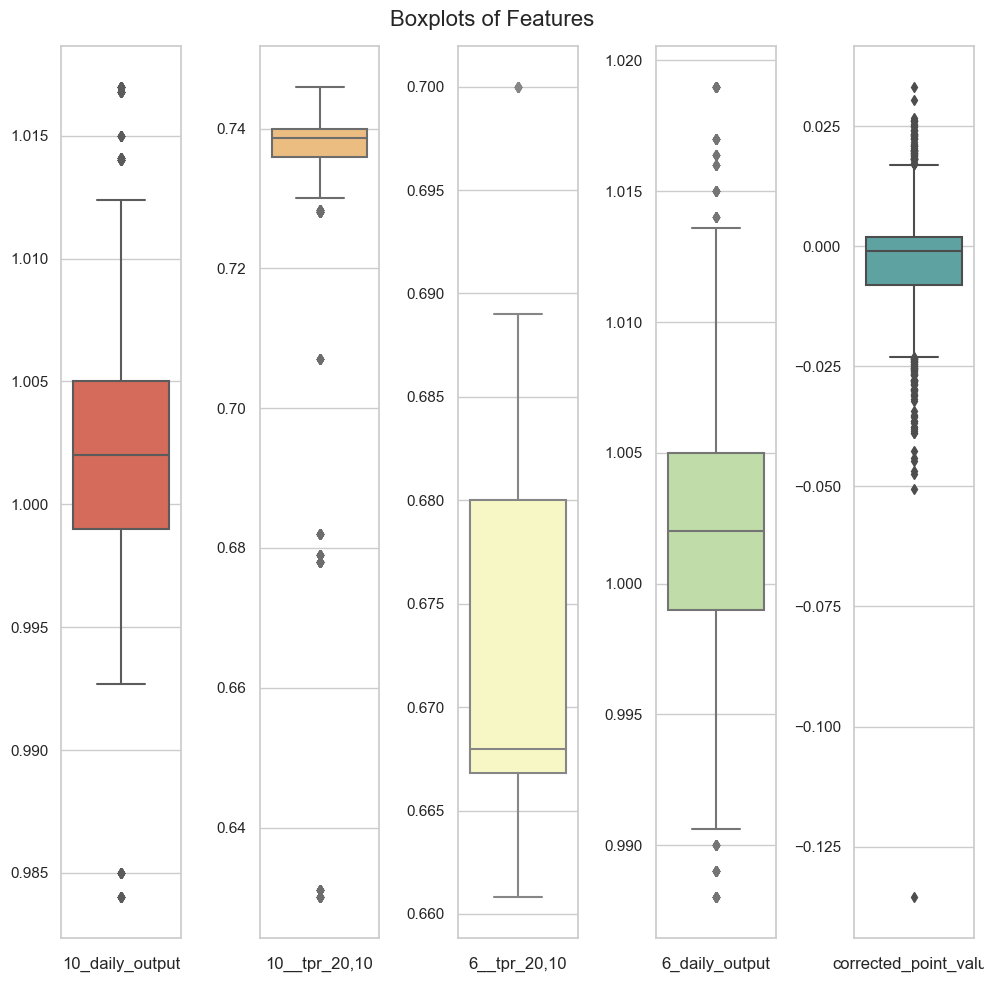

In [82]:
rows = 1
cols = 5
fig, ax = plt.subplots(nrows=1, ncols=5, squeeze= True, figsize = (10,10))
fig.suptitle("Boxplots of Features", fontsize = 16)
# fig.tight_layout(w_pad=2, h_pad=1)

for i in range(cols * rows):
    # row = i//5
    # column = i%5
    p = sns.boxplot(df[numerical_columns[i]], ax = ax[i], color = sns.color_palette('Spectral',5)[i])
    p.set(xlabel=numerical_columns[i])
    p.set(xticklabels="")
    
# ax[1,3].set_axis_off()
# ax[2,1].set_axis_off()
fig.tight_layout()

plt.savefig("Figures/Boxplots/All Boxplots of Features.png")
plt.show()

## Heatmap of numerical data

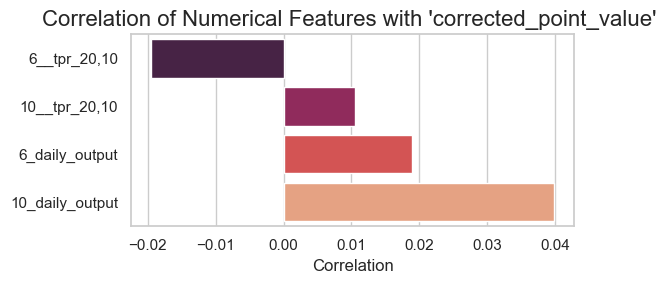

In [83]:
corr_data = df[numerical_columns[:-1]].corrwith(df["corrected_point_value"]).sort_values()

fig, ax = plt.subplots(figsize = (6,3))
sns.barplot(y = corr_data.index,  x = corr_data.values, orient='h', palette='rocket', ax = ax)
ax.set_xlabel("Correlation")
plt.title("Correlation of Numerical Features with 'corrected_point_value' ", fontsize = 16)
fig.tight_layout()
# ax.set_ylabel(" ",labelpad=30)


plt.savefig("Figures/Correlation with CPV.png", bbox_inches='tight')
plt.show()

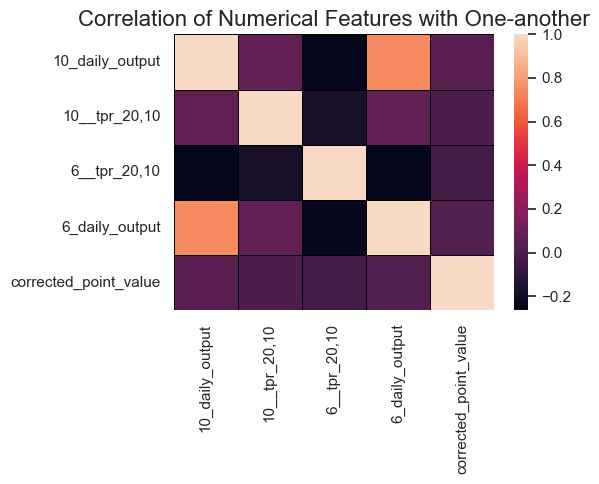

In [84]:
fig, ax = plt.subplots(figsize=(6,5))         # Sample figsize in inches

sns.heatmap(df[numerical_columns].corr(),linewidths=0.5, linecolor='black', ax=ax, center = 0.4, cmap = ("rocket"))
plt.title("Correlation of Numerical Features with One-another", size = 16)
fig.tight_layout()
plt.savefig("Figures/Heatmap.png",bbox_inches='tight')
plt.show()

In [30]:
# per_case_manuf_values = df[["manuf","point_value","case"]].groupby(["case","manuf"]).median()

In [31]:
# dfs = []
# for case, new_df in per_case_manuf_values.groupby(level=0):
#     dfs.append(new_df)

# sns.set(rc={'figure.figsize':(5,4)})
# sns.set_style("whitegrid")

# for index, data in enumerate(dfs):
#     case = data.reset_index()["case"][0]
    
#     clean_df = data.reset_index().drop(columns = 'case')
#     manuf = clean_df["manuf"].values
    
#     plot = sns.barplot(data = clean_df, x = "manuf", y = "point_value")
#     plt.title(f"case {case}")
#     plot.tick_params(labelrotation=15)
#     plot.set_title(f"case {case}", size = 16)
    
#     plot.bar_label(plot.containers[0])
    
#     plot.set_ylabel("Mean of predicted value")
    
#     if len(str(case)) == 1:
#         case = "0" + str(case)
    
#     file_name = "Case " + str(case)
#     print(file_name)
#     # plt.savefig("Figures/manuf by Case/" + file_name, bbox_inches='tight')
#     plt.show()

In [32]:
# dfs = []
# for case, new_df in per_case_manuf_values.groupby(level=0):
#     dfs.append(new_df)
    
# fig, ax = plt.subplots(ncols = 4, nrows = 2, figsize = (20,10))

# for index, data in enumerate(dfs):
#     case = data.reset_index()["case"][0]
    
#     clean_df = data.reset_index().drop(columns = 'case')
#     manuf = clean_df["manuf"].values
    
#     col = index%4
#     row = index//4
    
#     plot = sns.barplot(data = clean_df, x = "manuf", y = "point_value", ax = ax[row, col])
#     plt.title(f"case {case}")
#     ax[row,col].tick_params(labelrotation=15)
#     ax[row,col].set_title(f"case {case}", size = 16)
    
#     ax[row,col].bar_label(plot.containers[0])
    
#     ax[row,col].set_ylabel("Median of predicted value")

# fig.suptitle("Comparing Manufactureres by Case", size = 20)
# fig.tight_layout(pad=2)

# plt.savefig("Figures/Comparing_Manufacturers_by_Case.png")
# plt.show()

## Analysing Manufacturer - Algorithm data
### Every case and every point type

In [7]:
data = pd.read_csv("Cleansing the data/FINAL_DATA.csv", low_memory=False)

In [86]:
# # For every point
# for point_type in data["point_type"].value_counts().keys():
#     for case in cases:
#         file_path = "Cleansing the data/Datasets by Case/Case3_Corrected/case_" + str(case) + "_corrected.csv"
#         df_caseX = pd.read_csv(file_path)
#         df_caseX_pp = df_caseX[["manuf","algorithm","point_type","point_value"]][df_caseX["point_type"] == point_type]
#         df_caseX_pp["point_value%"] = df_caseX_pp["point_value"] * 100

#         hmap = sns.heatmap(pd.pivot_table(df_caseX_pp,
#                                           index='algorithm',
#                                           columns='manuf', 
#                                           values='point_value%'),
#                           annot = True,
#                           linewidths=0.5, 
#                           linecolor='black')
        
#         for t in hmap.texts: t.set_text(t.get_text() + " %")
#         hmap.set_title("CASE " + str(case) + ": " + str(point_type) + " (Mean)")
#         plt.xticks(rotation = 15)
        
#         path = "Figures/Algo_manuf_mean/Heatmaps/"+str(point_type)+"/Case_" + str(case) + ".png"
        
#         if not isfile(path):
#             plt.savefig(path, bbox_inches='tight')
#             print("Figure Saved!")
            
#         plt.show()

In [87]:
# from pathlib import Path
# sns.set_style("whitegrid")
# # For every point
# for point_type in data["point_type"].value_counts().keys():
#     for case in cases:
#         file_path = "Datasets by Case/CSV/Case_" + str(case) + ".csv"
#         df_caseX = pd.read_csv(file_path)
#         df_caseX_pp = df_caseX[["manuf","algorithm","point_type","point_value"]][df_caseX["point_type"] == point_type]
#         df_caseX_pp["point_value%"] = df_caseX_pp["point_value"] * 100

#         pd.pivot_table(df_caseX_pp,
#                       index='algorithm',
#                       columns='manuf', 
#                       values='point_value%').plot.barh(figsize=(10,7), title = "CASE " + str(case) + ": " + str(point_type) + " (Mean)")

#         plt.legend()
        
#         path = "Figures/Algo_Manuf_mean/HBar Graphs/"+str(point_type)+"/Case_" + str(case) + ".png"
#         if not Path(path).is_file():
#             plt.savefig(path, bbox_inches='tight')
#             print("Figure Saved!")
            
#         plt.show()

In [8]:
data['point_type'].value_counts()

Prescription Point    4183
Worst Point -ve       3903
Worst Point +ve       3828
Name: point_type, dtype: int64

Save figures? [y/n] y


Figure Saved!


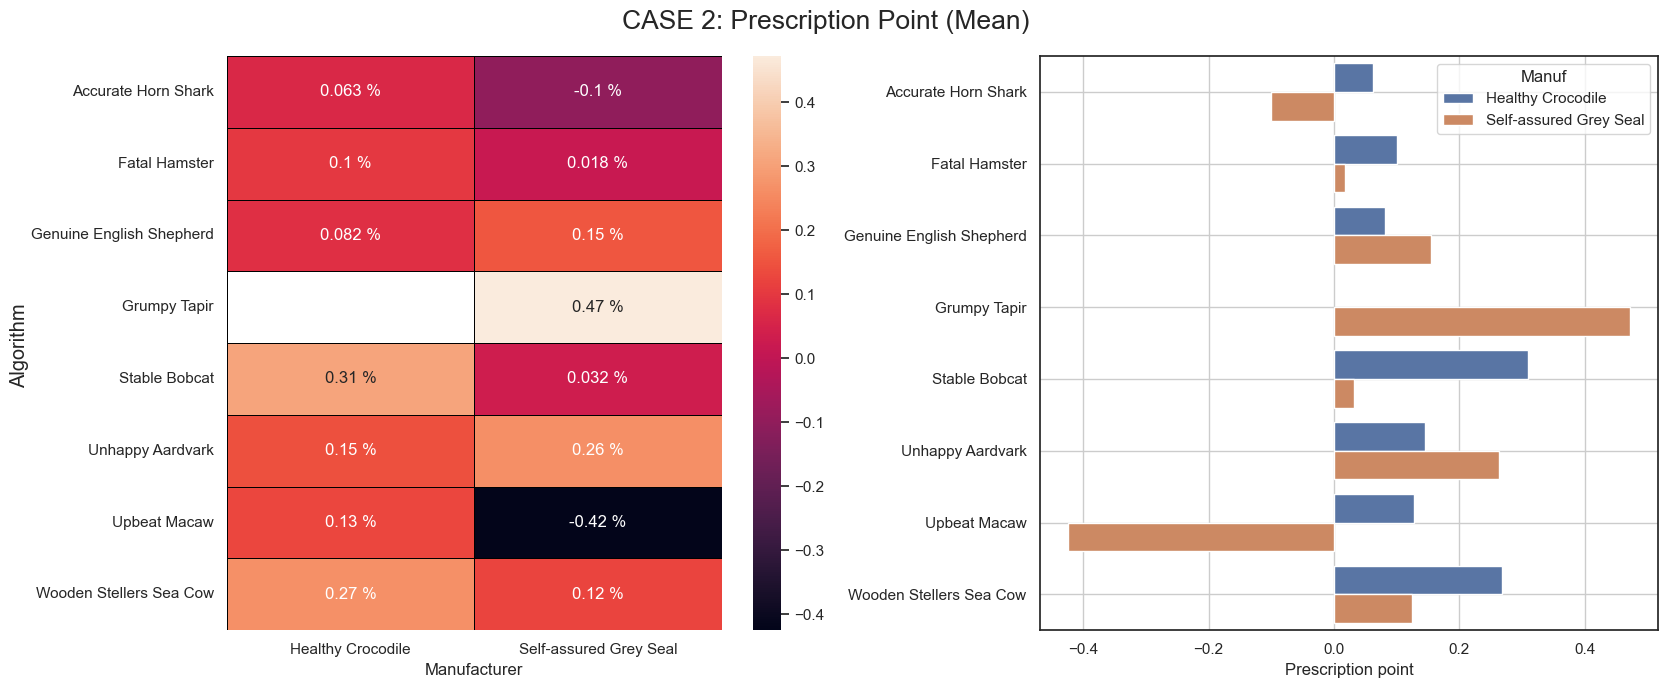

Figure Saved!


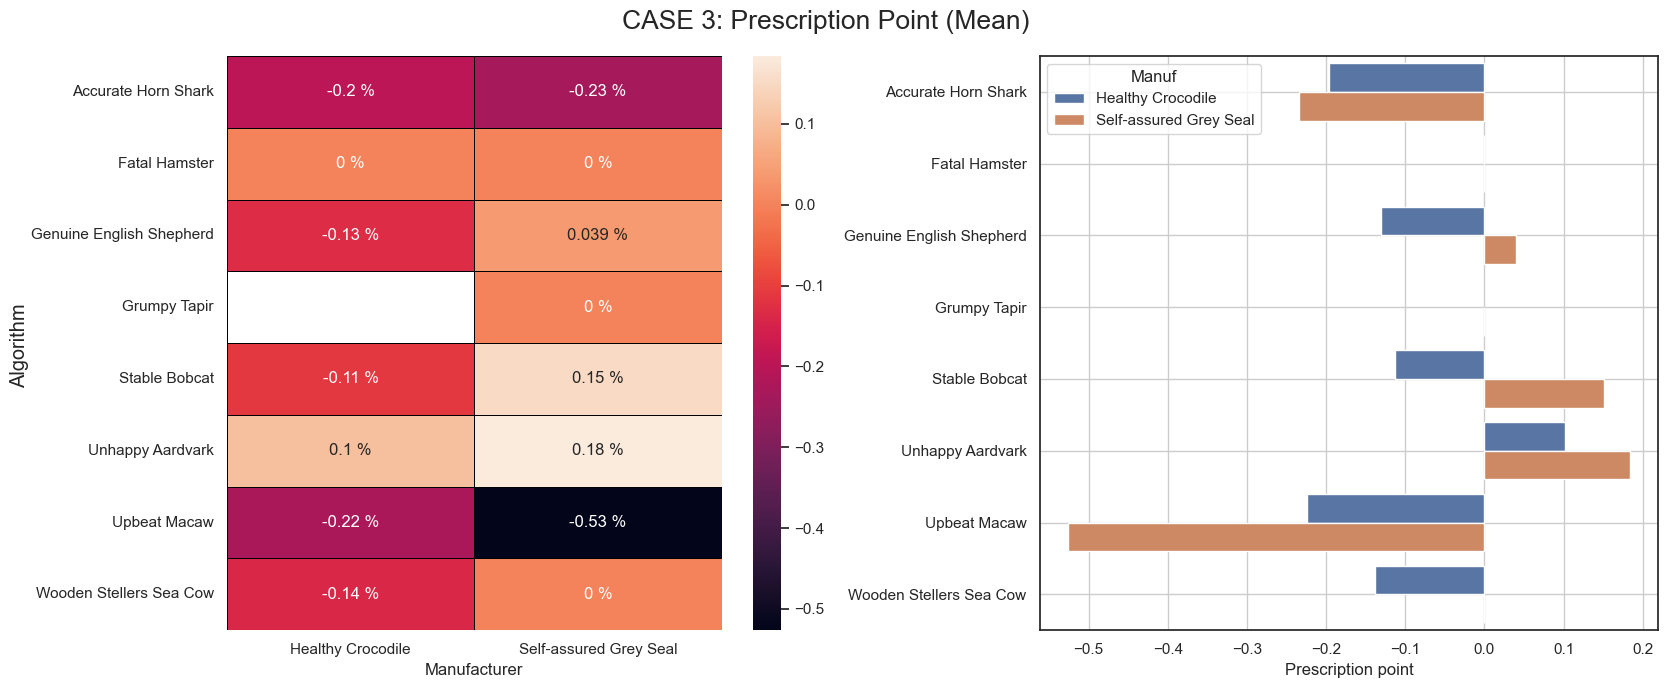

Figure Saved!


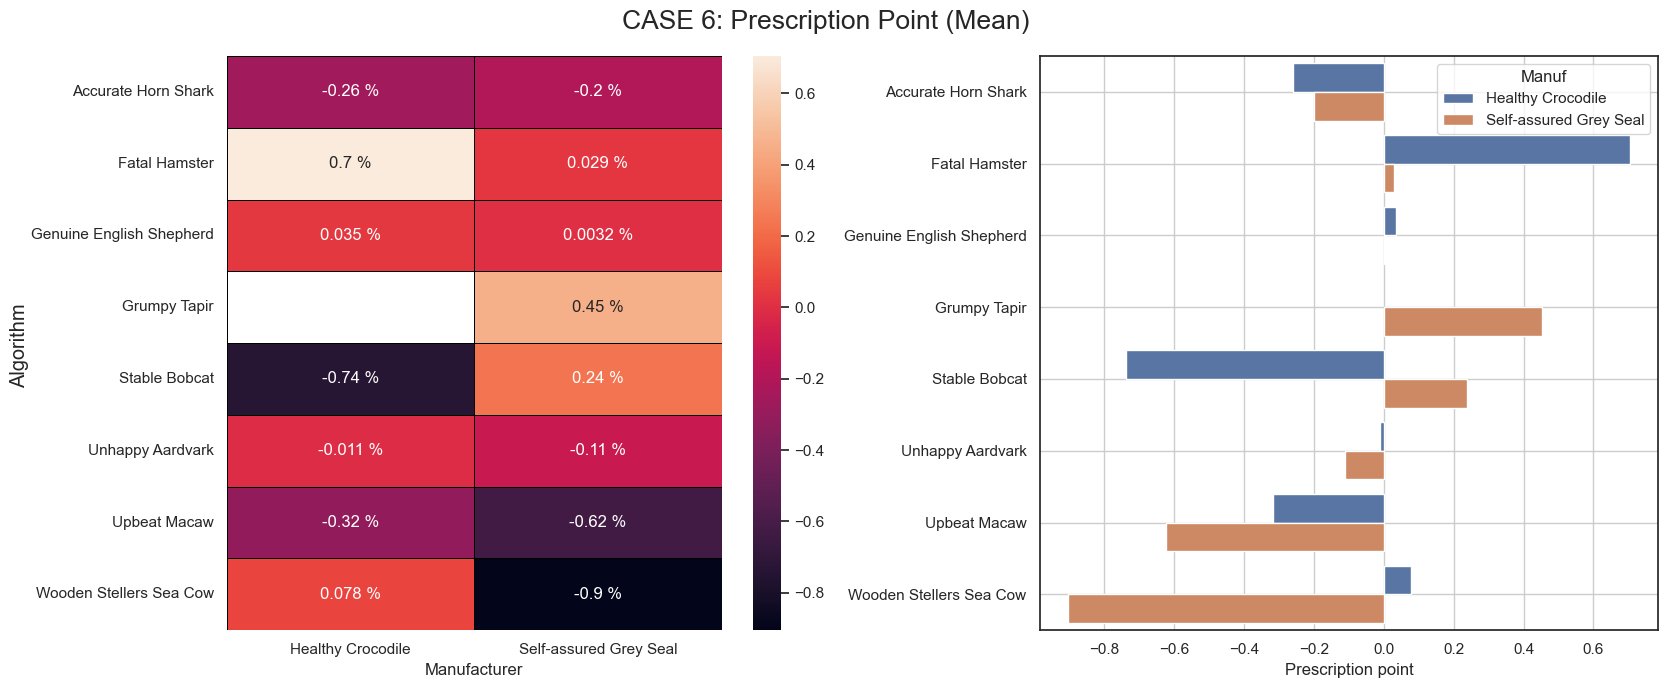

Figure Saved!


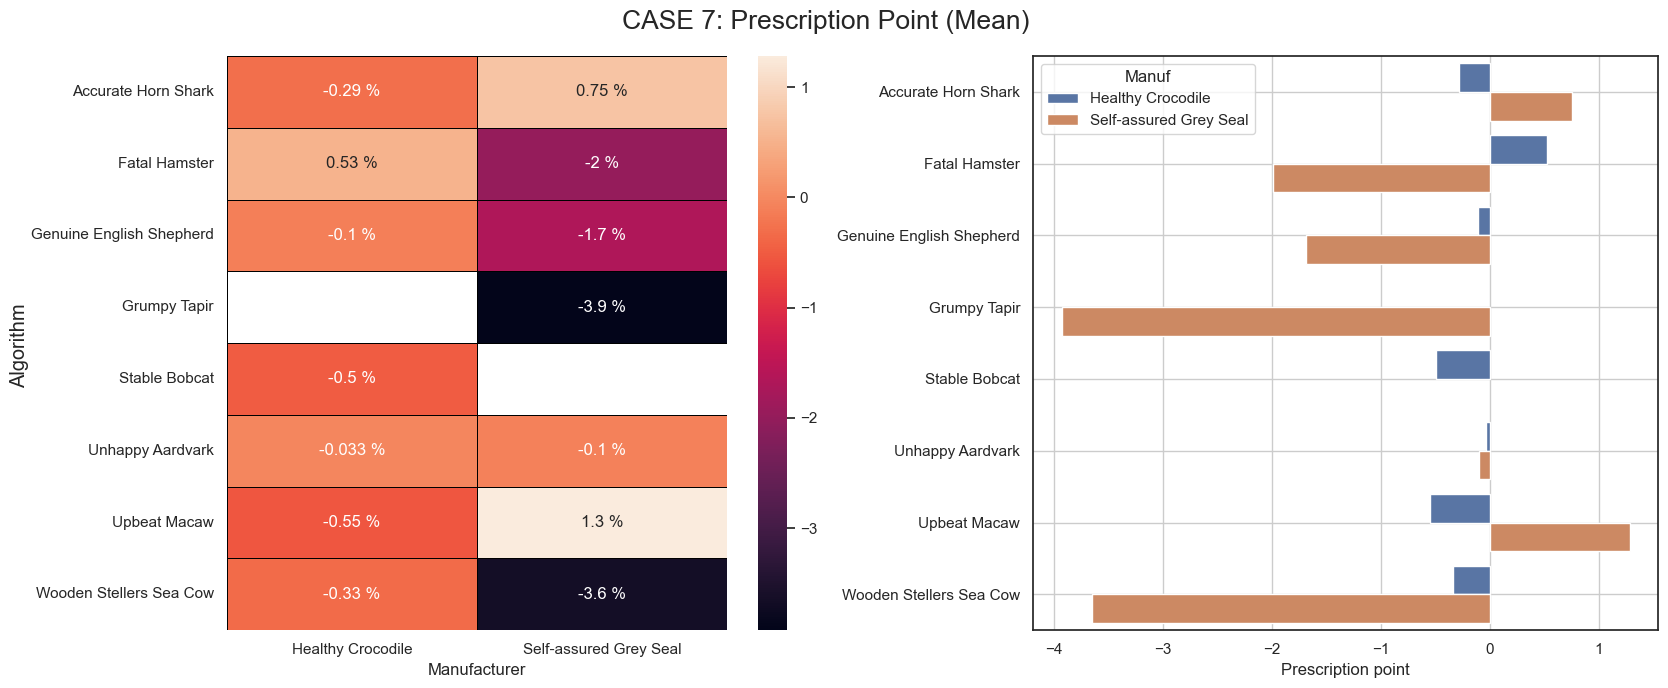

Figure Saved!


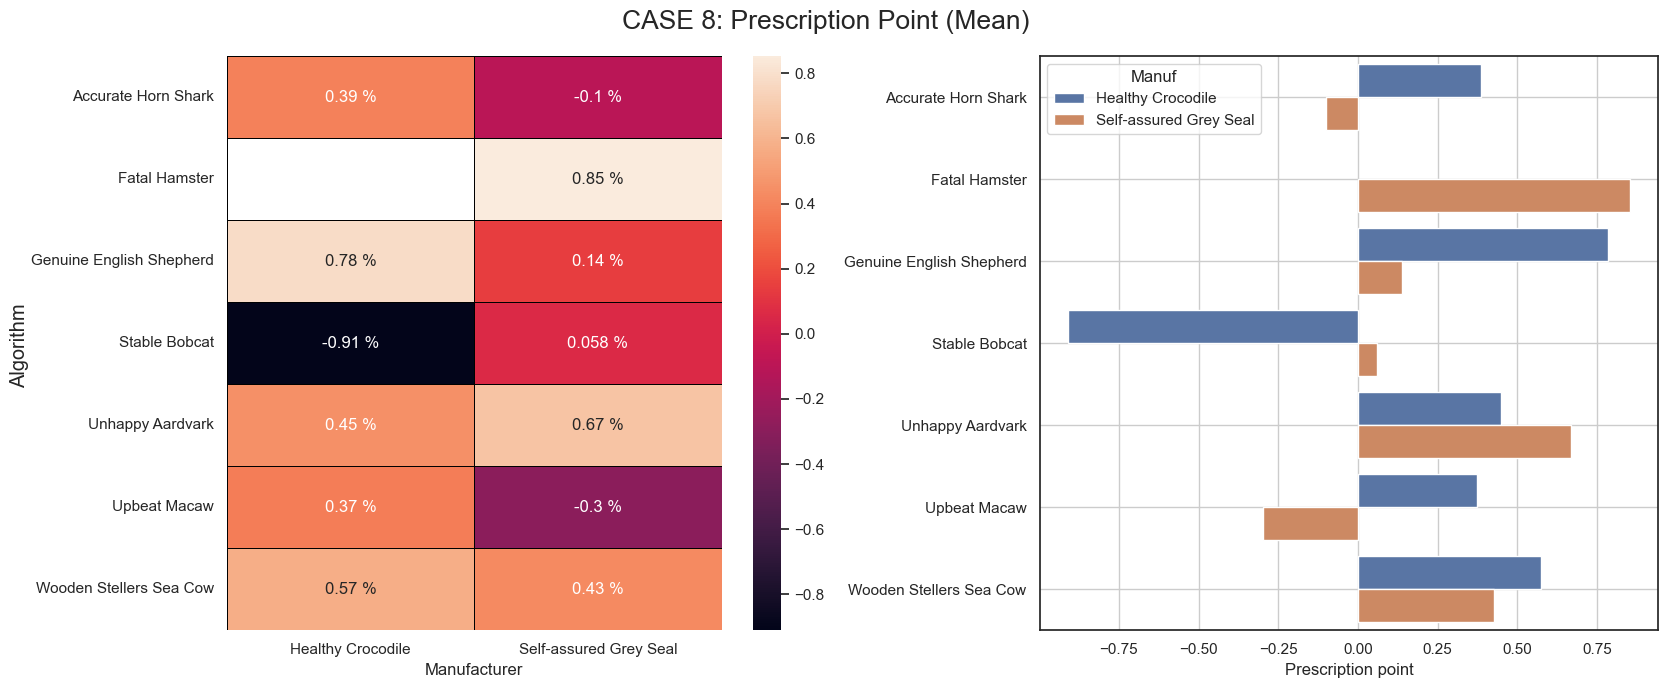

Figure Saved!


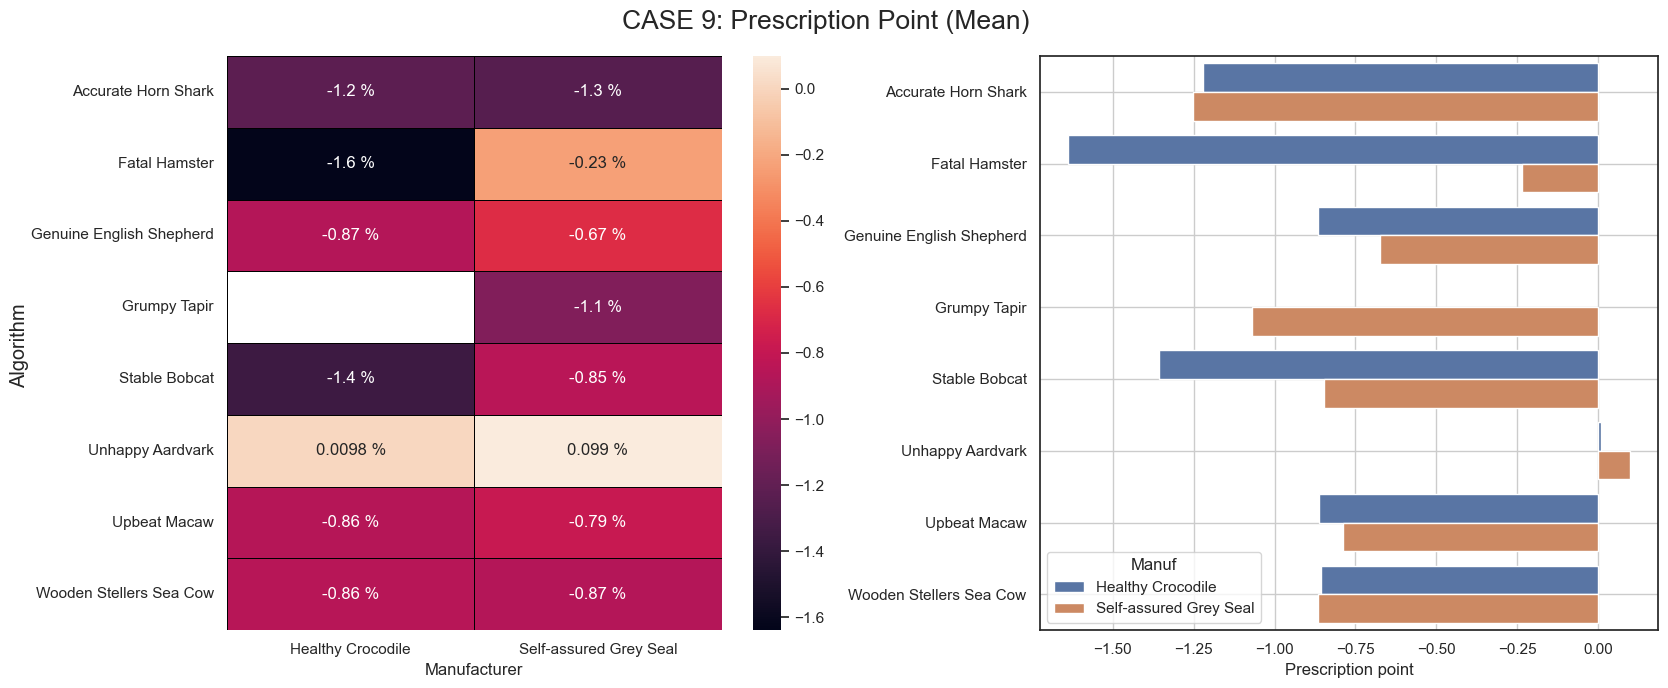

Figure Saved!


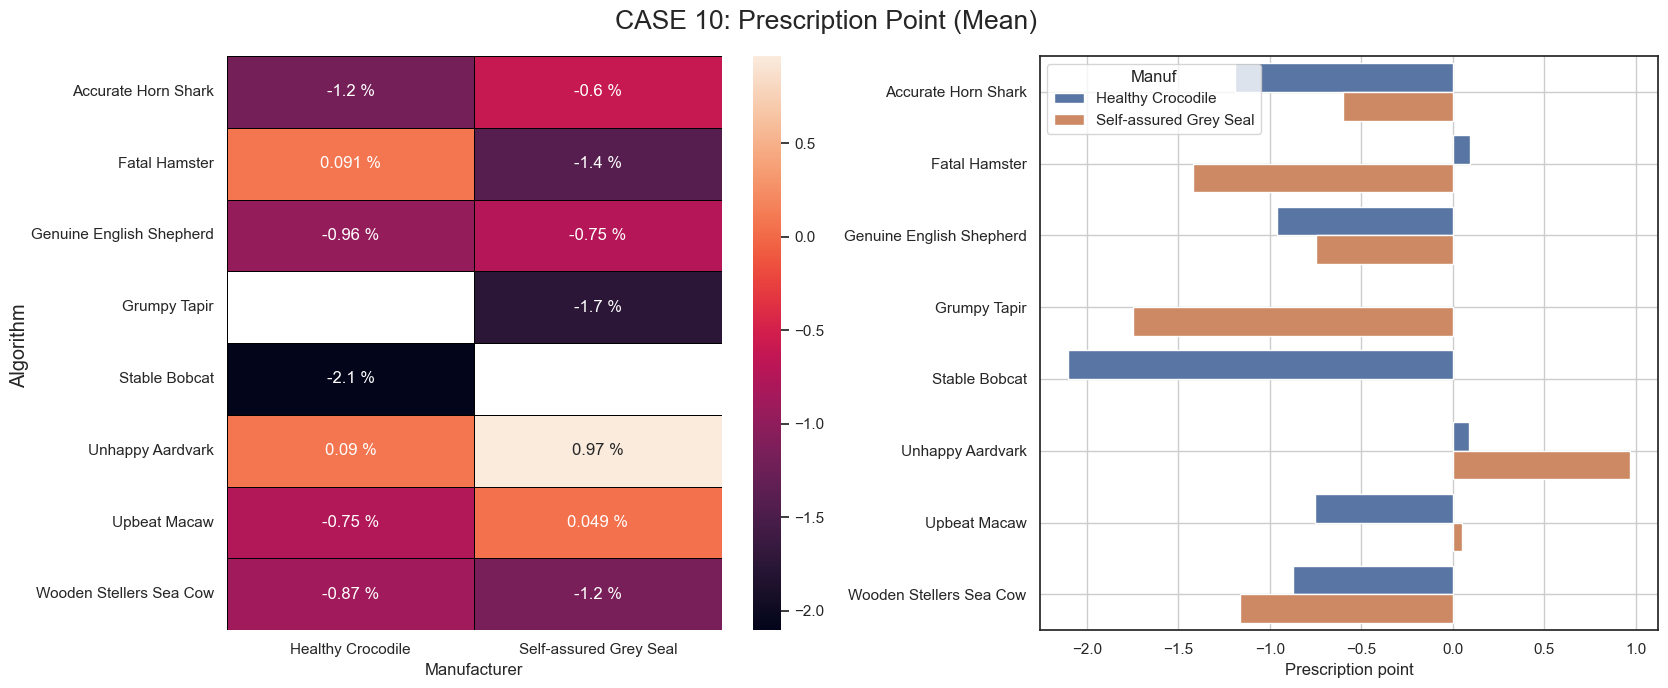

Figure Saved!


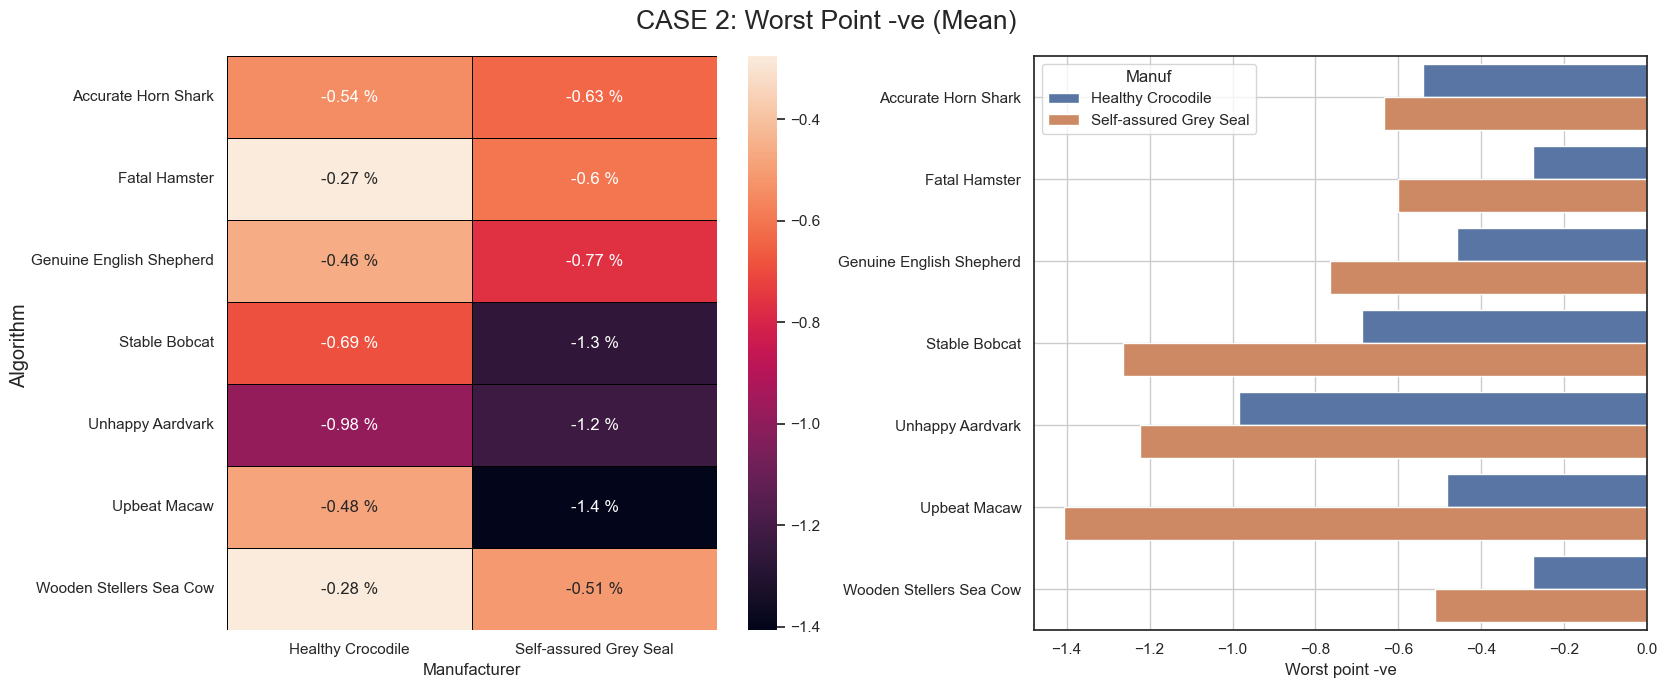

Figure Saved!


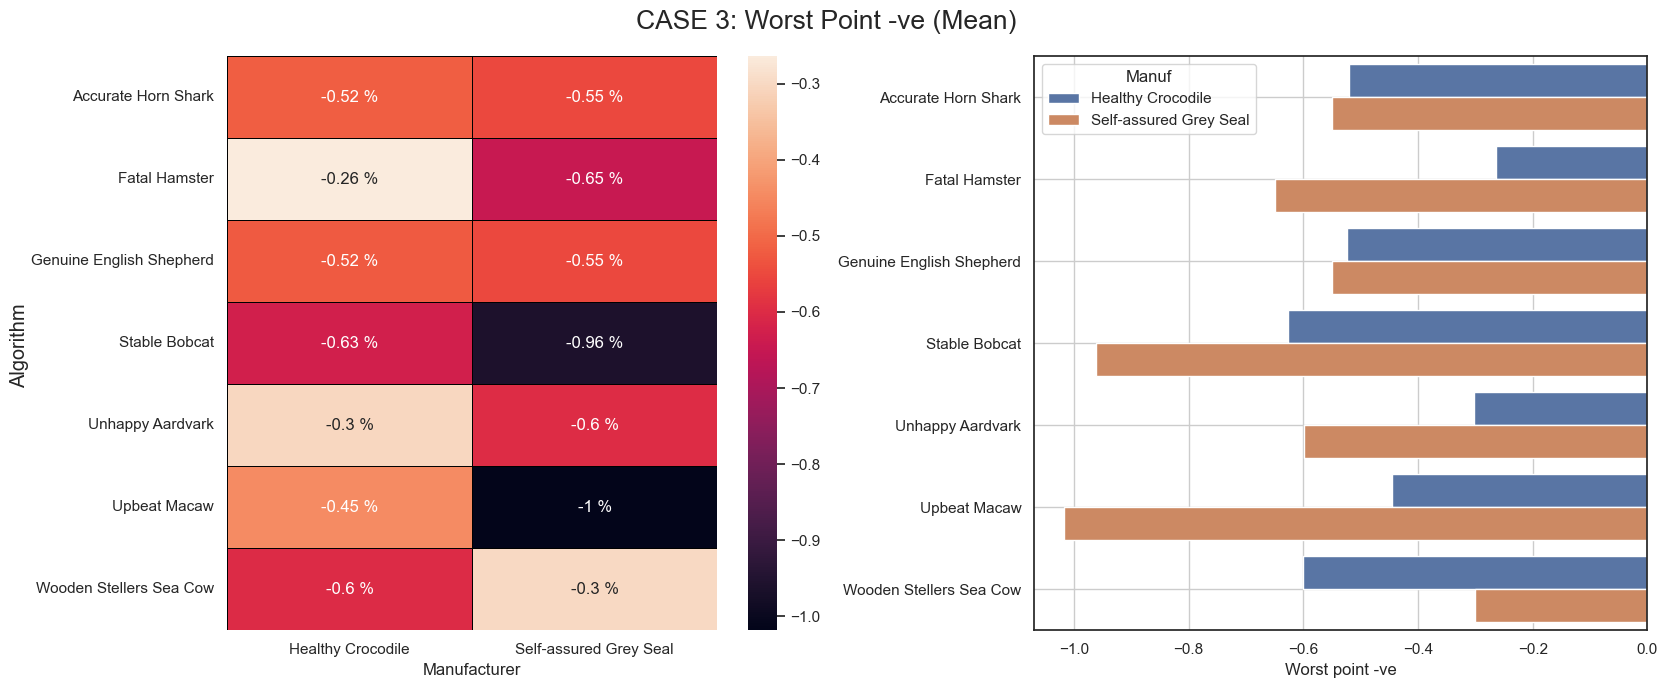

Figure Saved!


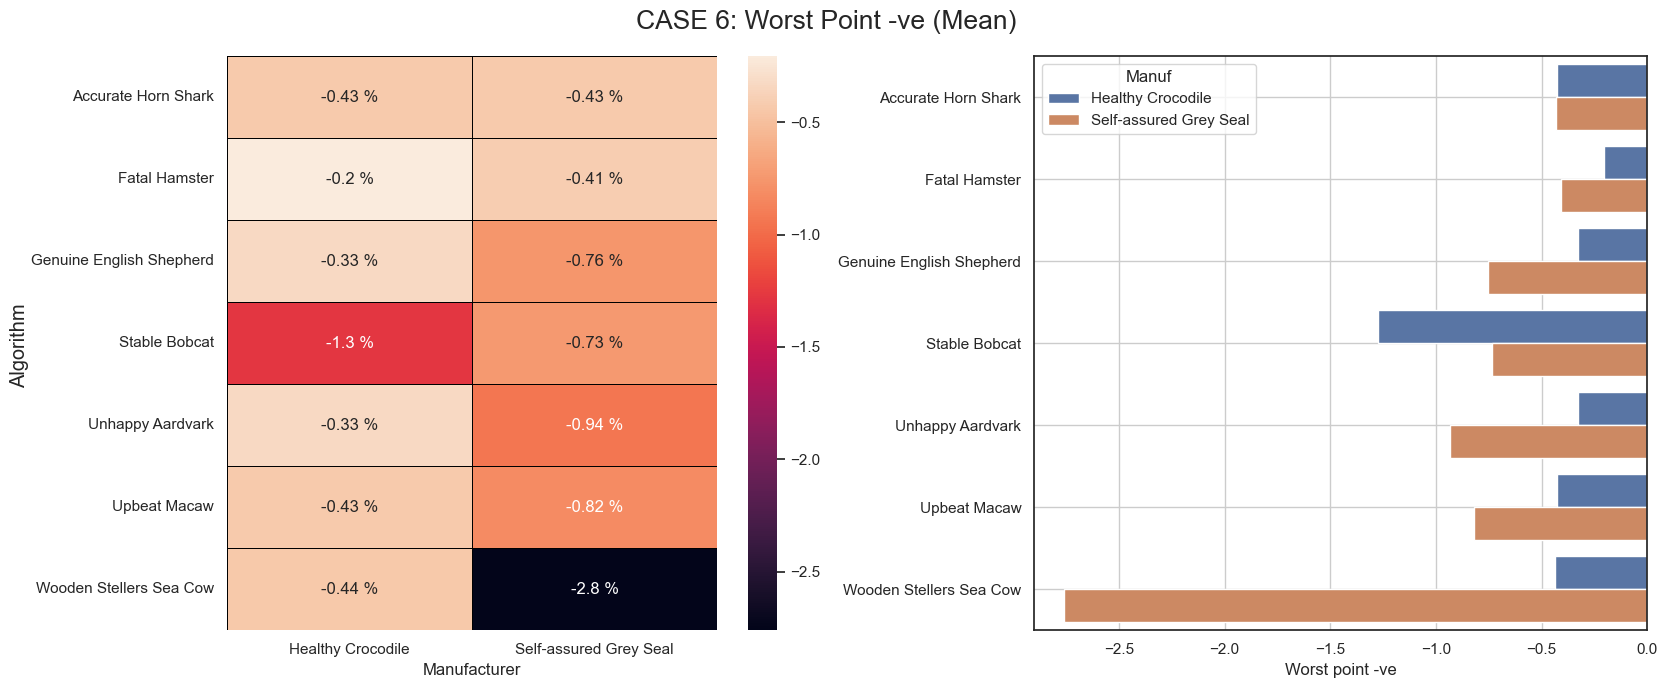

Figure Saved!


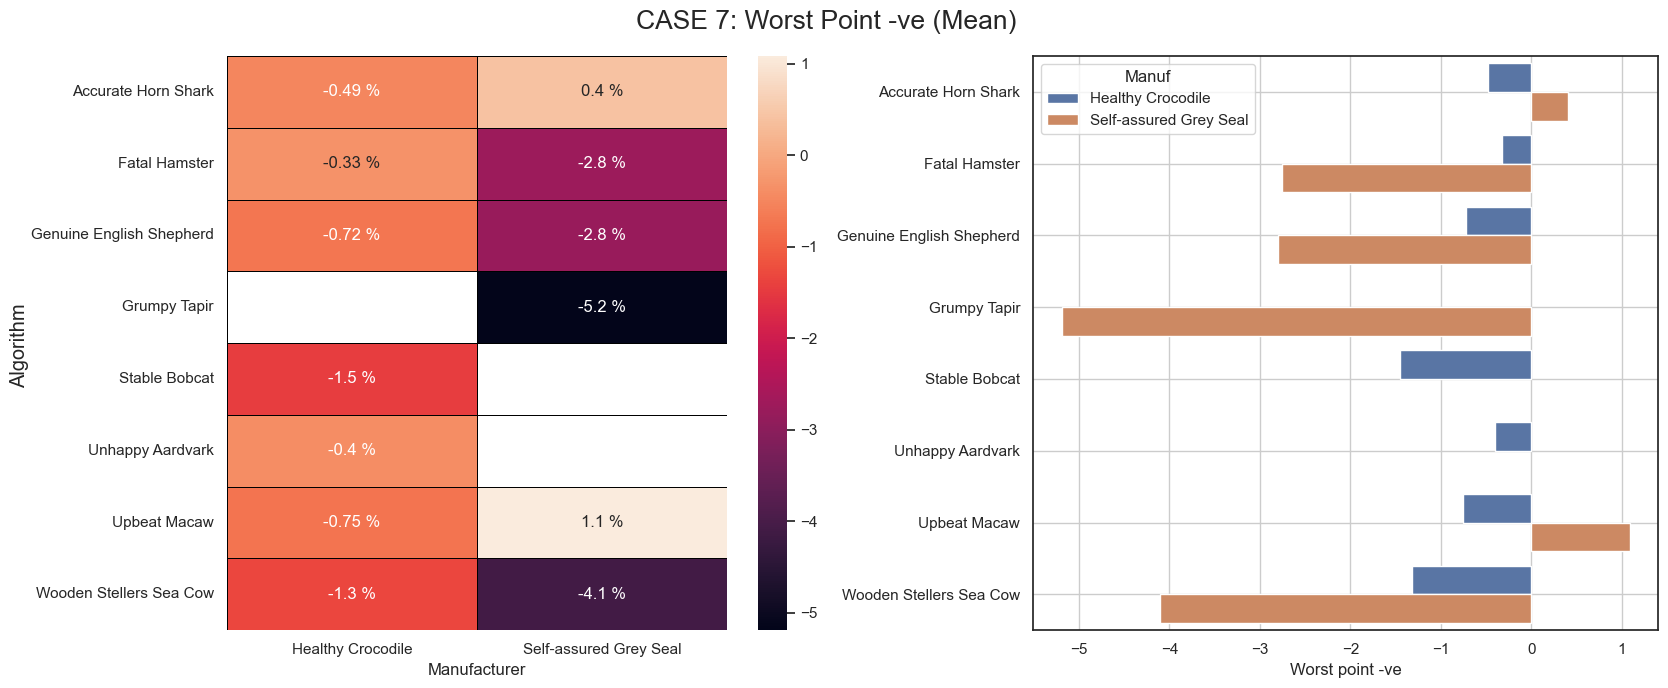

Figure Saved!


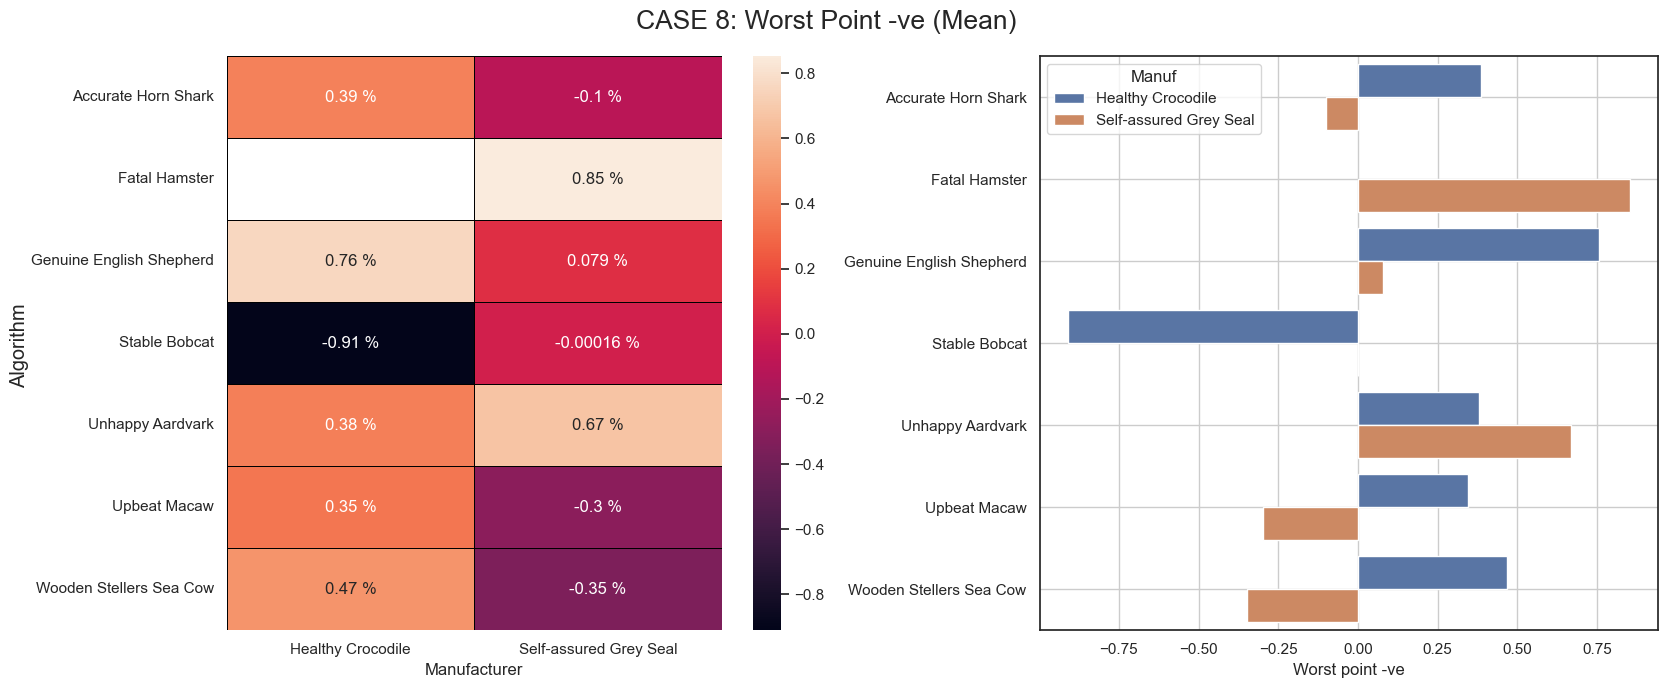

Figure Saved!


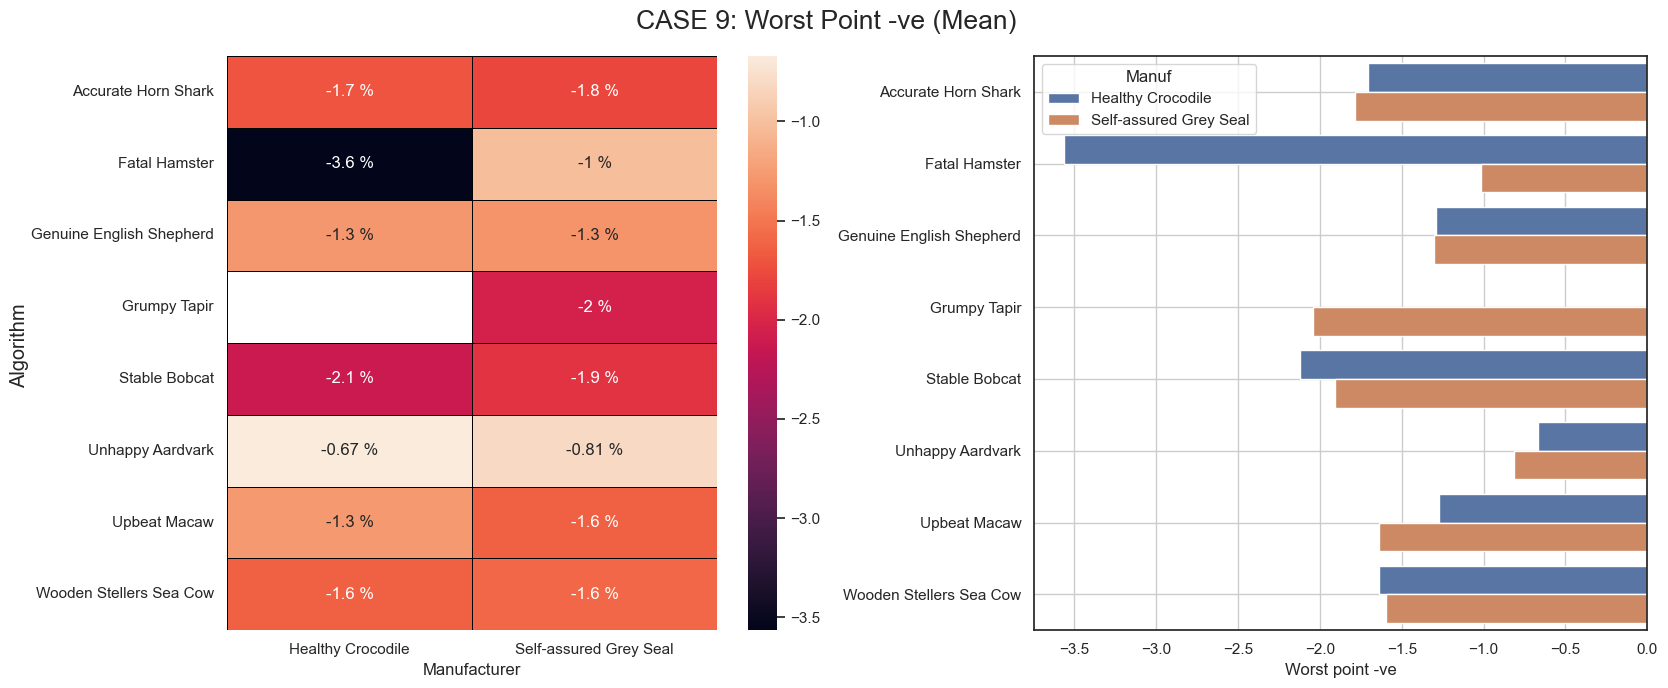

Figure Saved!


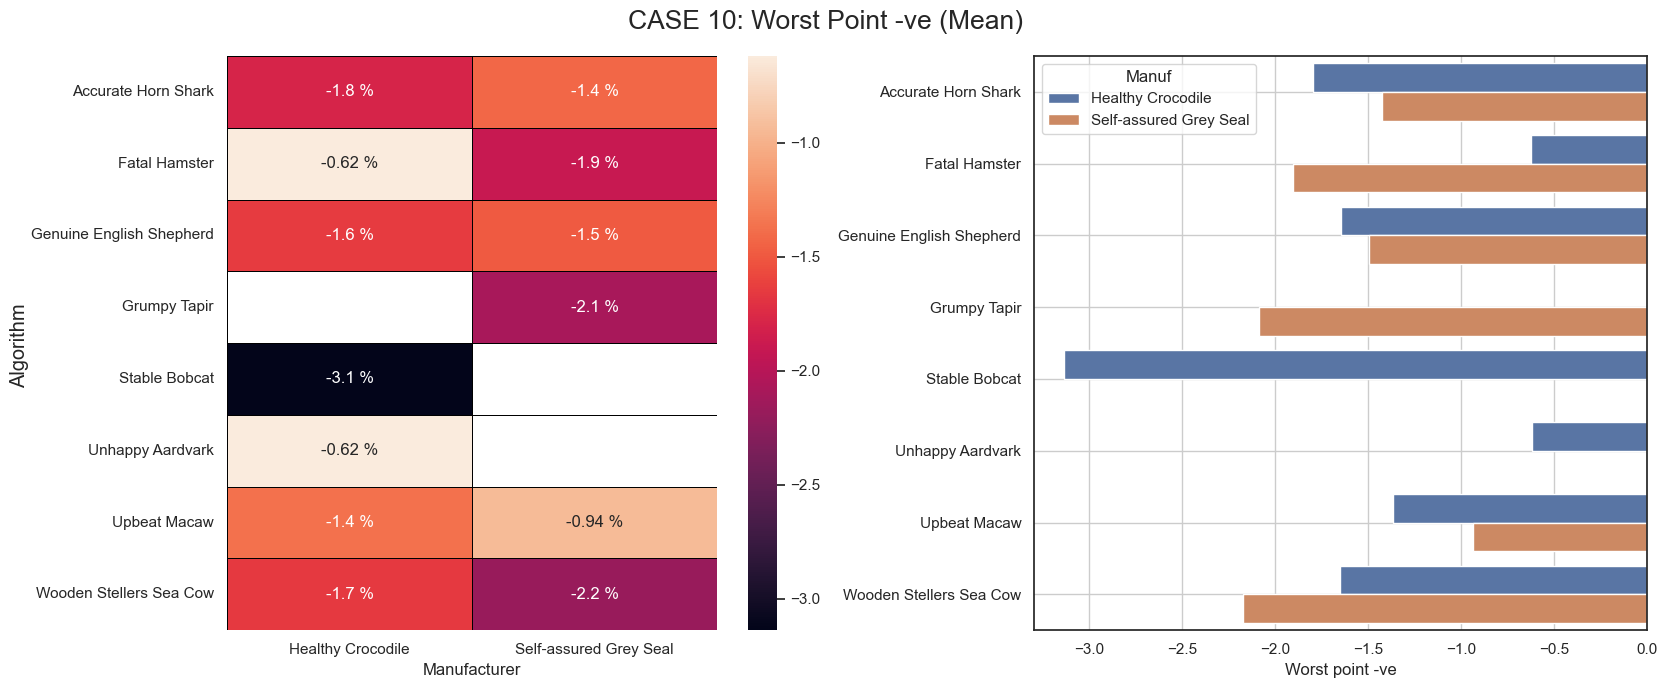

Figure Saved!


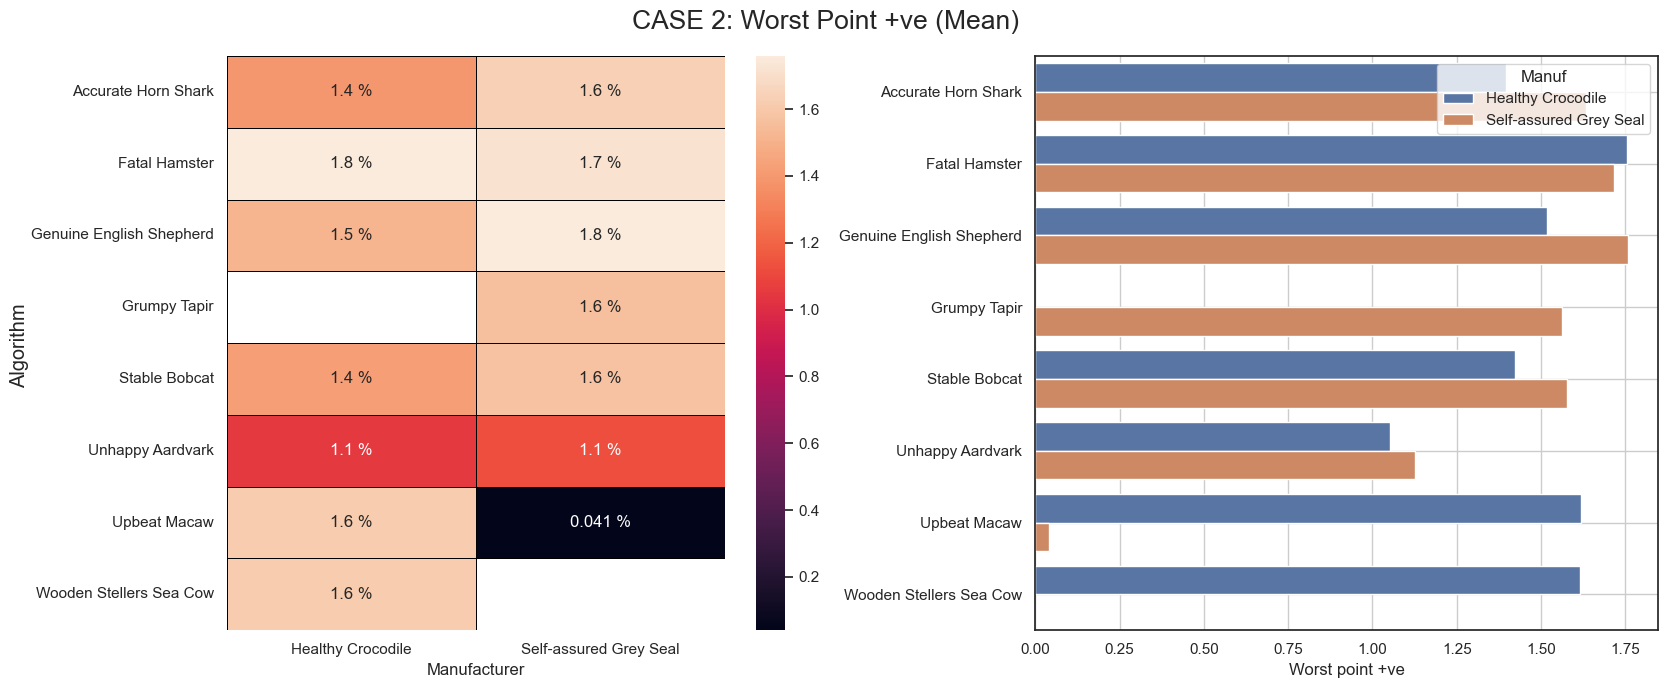

Figure Saved!


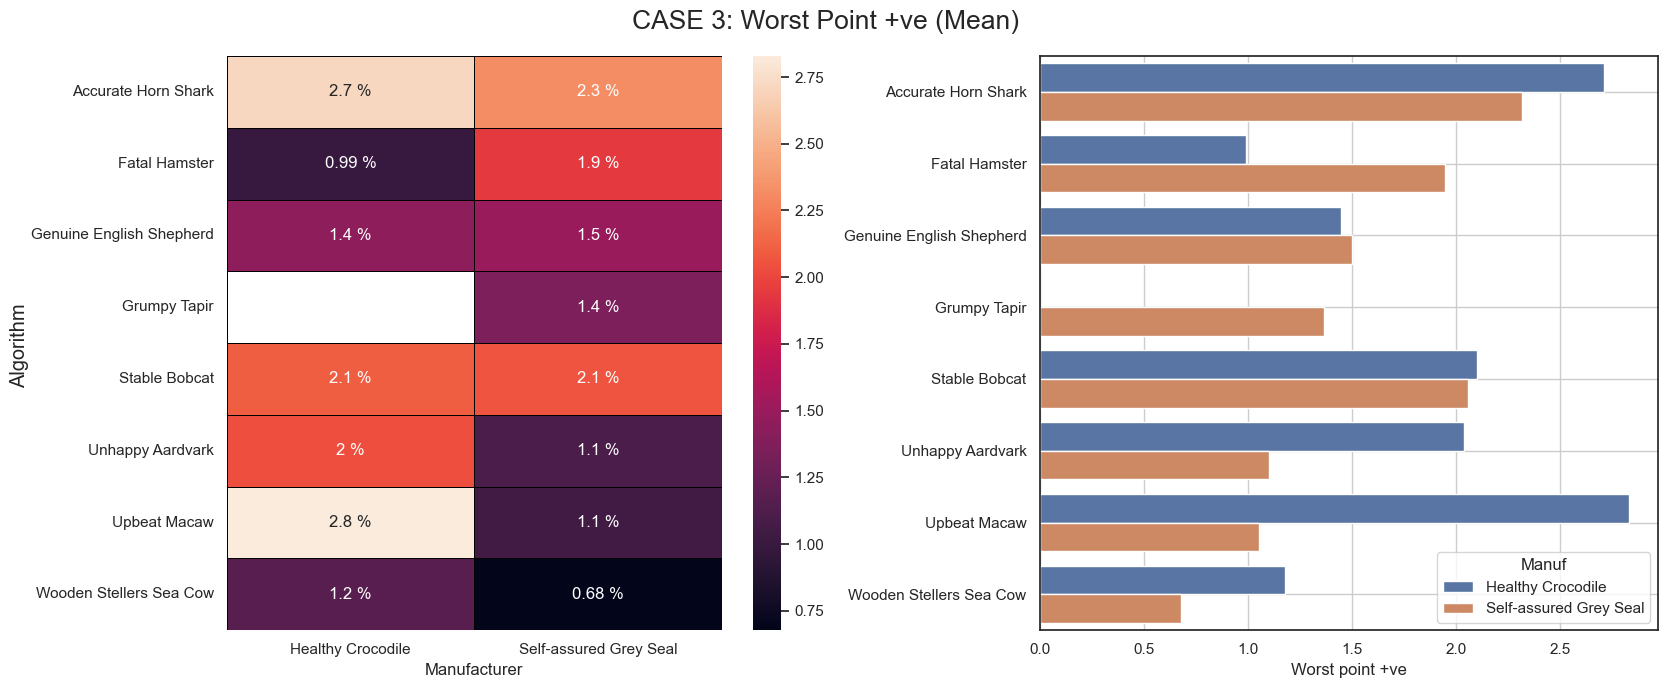

Figure Saved!


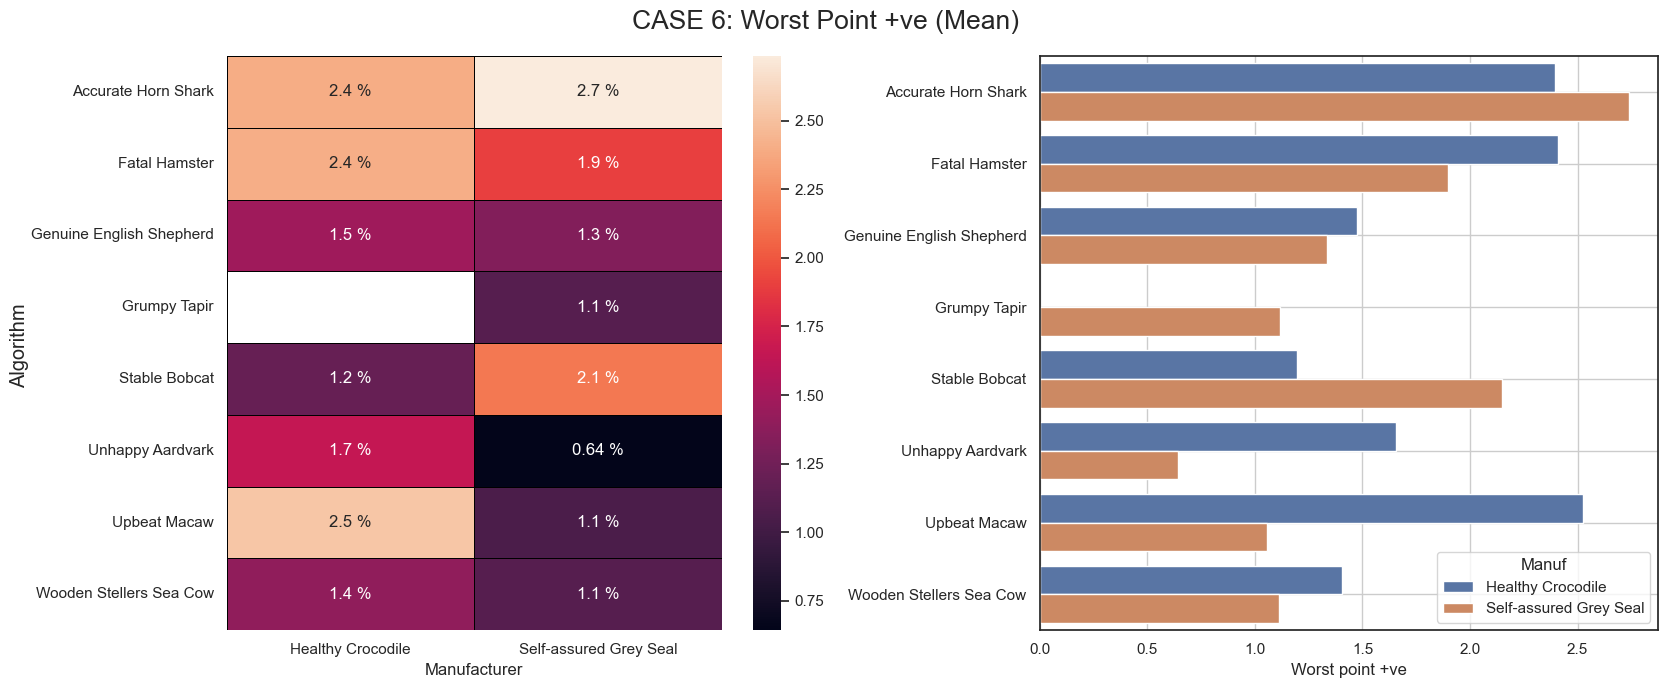

Figure Saved!


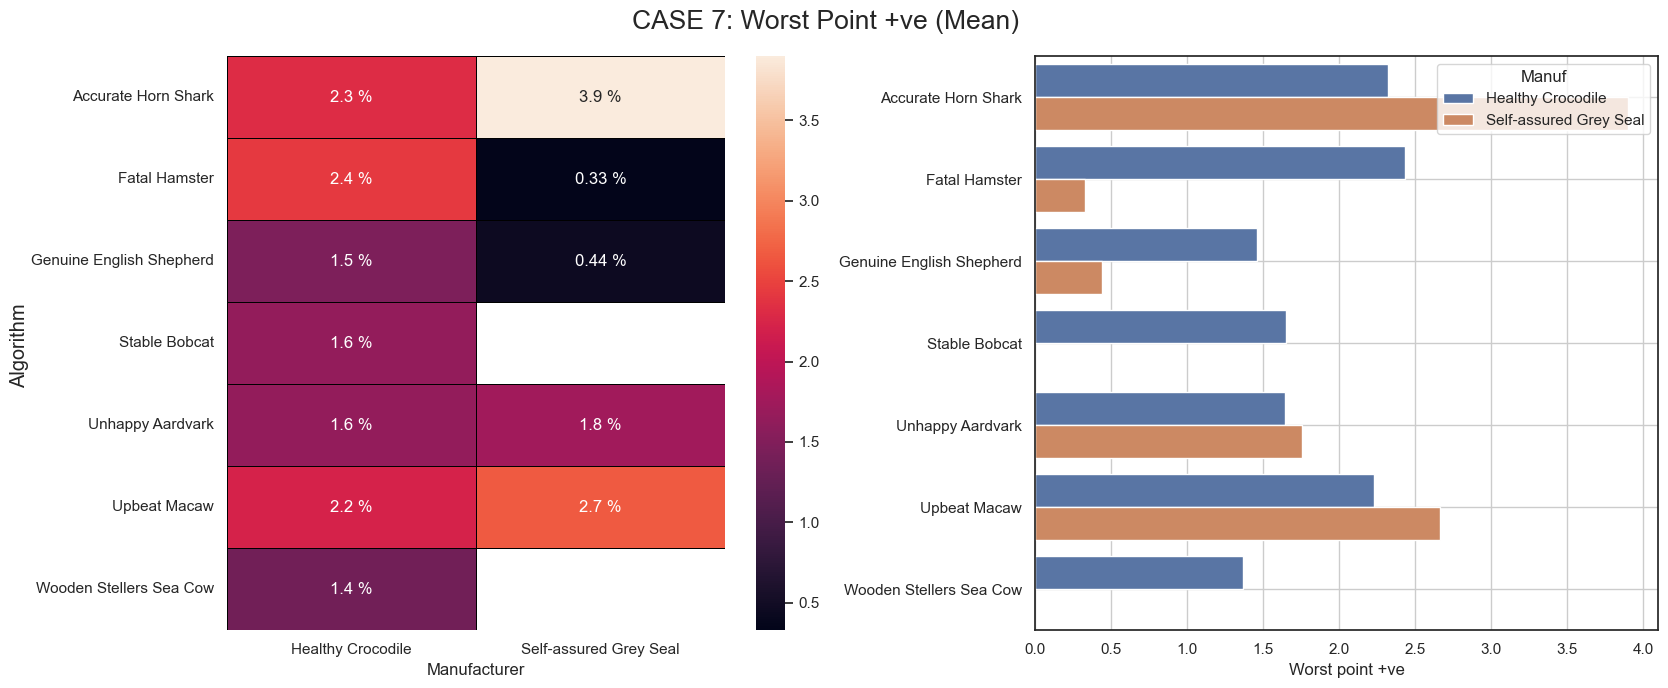

Figure Saved!


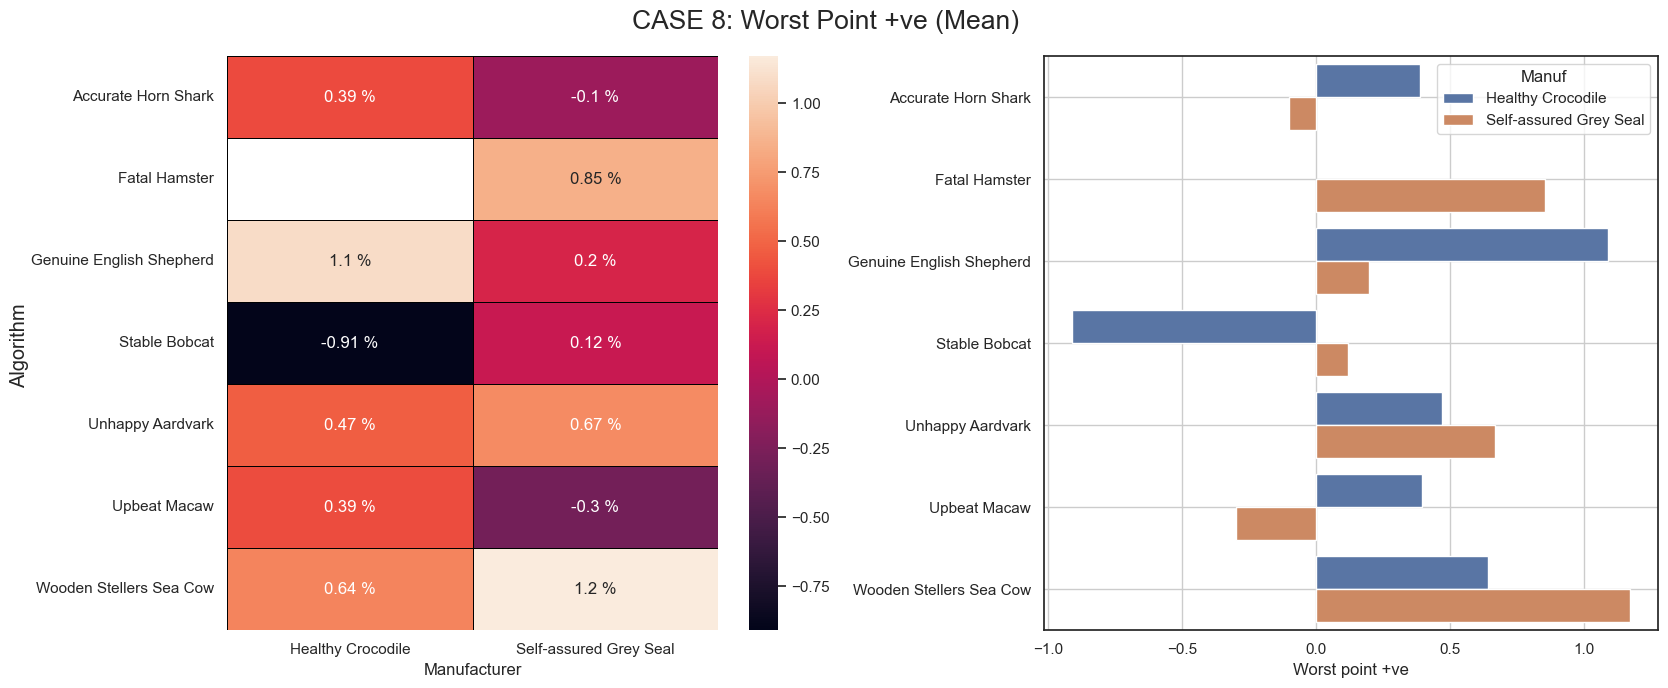

Figure Saved!


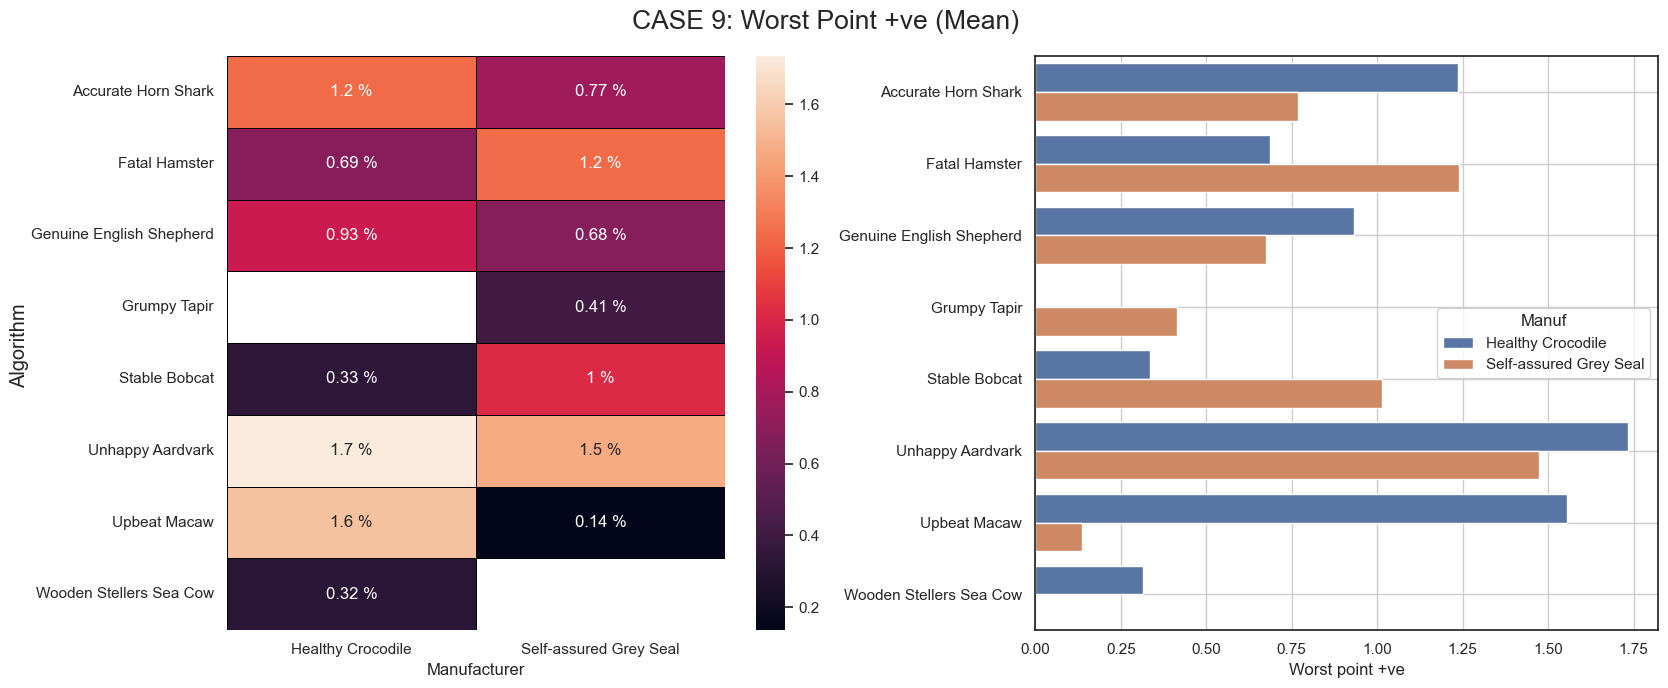

Figure Saved!


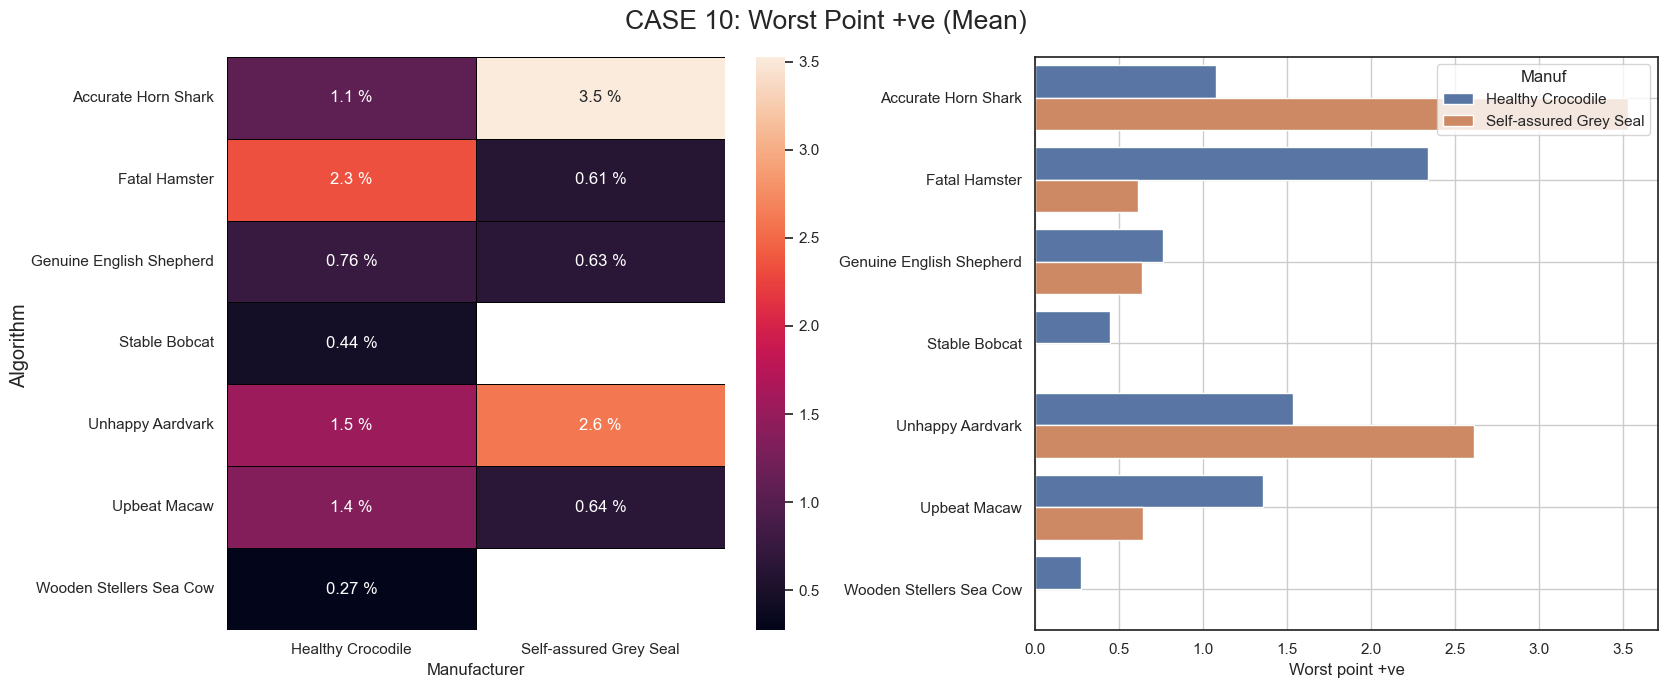

In [104]:
# For every point
import numpy as np
sns.set_style('white')
save = input("Save figures? [y/n]")

for point_type in data["point_type"].value_counts().keys():
    for case in cases:
        fig, (ax1,ax2) = plt.subplots(1,2, figsize = (17,7))
        file_path = "Cleansing the data/Datasets by Case/Case3_Corrected/case_" + str(case) + "_corrected.csv"
        df_caseX = pd.read_csv(file_path)
        df_caseX_pp = df_caseX[["manuf","algorithm","point_type","corrected_point_value"]][df_caseX["point_type"] == point_type]
        df_caseX_pp["corrected_point_value%"] = df_caseX_pp["corrected_point_value"] * 100
        
        pt = pd.pivot_table(df_caseX_pp,
                              index='algorithm',
                              columns='manuf', 
                              values='corrected_point_value%')
        #HEATMAP
        hmap = sns.heatmap(pt,
                          annot = True,
                          linewidths=0.5, 
                          linecolor='black',
                          ax = ax1)
        hmap.set_xlabel("Manufacturer")
        hmap.set_ylabel("")
        
        for t in hmap.texts: t.set_text(t.get_text() + " %")
        
        #BARPLOT
        pt_reset = pt.stack().reset_index()
        bplot = sns.barplot(pt_reset,
                            y = 'algorithm',
                            x = pt_reset[0], 
                            hue = 'manuf', 
                            orient = 'h', 
                            ax = ax2)
        bplot.set_ylabel("")
        bplot.set_xlabel(str(point_type).capitalize())
        bplot.legend_.set_title("Manuf")
        bplot.legend_.get_draggable()
        
        fig.suptitle("CASE " + str(case) + ": " + str(point_type) + " (Mean)", size = 19)
        fig.supylabel("Algorithm")
        fig.tight_layout()
        plt.grid()
        
        path = "Figures/Algo_manuf_mean/"+str(point_type)+"/Case_" + str(case) + ".png"
        
        if save == 'y':
            plt.savefig(path, bbox_inches='tight')
            print("Figure Saved!")
            
        plt.show()

In [20]:
data.columns

Index(['predicted_id', 'new_audit_id', 'audit_id', 'facility_id', 'status',
       'auditor1', 'auditor2', 'auditor3', 'date', 'manuf', 'model', 'tps',
       'algorithm', 'matched', 'k_q fac.', 'k_q acds', 'array', 's.n.',
       'audit', '6_daily_output', '10_daily_output', '15_daily_output',
       '18_daily_output', '6fff_daily_output', '10fff_daily_output',
       '6__tpr_20,10', '10__tpr_20,10', '15__tpr_20,10', '18__tpr_20,10',
       '6fff__tpr_20,10', '10fff__tpr_20,10', 'version', 'corr.', 'alg.',
       'rev.', 'metric', 'case', 'depth', 'energy', 'energy_fff', 'gantry',
       'mode', 'point_type', 'point_value', 'corrected_point_value'],
      dtype='object')

# Getting Manuf, algorithm, tps combinations for which mean prescription point is more than threshold levels

In [6]:
data = pd.read_csv("Cleansing the data/FINAL_DATA.csv", low_memory=False)

data_pp = data[data["point_type"] == "Prescription Point"]
data_neg = data[data["point_type"] == "Worst Point -ve"]
data_pos = data[data["point_type"] == "Worst Point +ve"]

In [7]:
results_df = pd.DataFrame(columns=["case","manuf","algorithm","tps","mean_corrected_value","count"])
def aggregate(dataframe, column_list, results_df):
    algo = None
    manuf = None
    tps = None
    case = None
    mean_value = None

    index_list = column_list.copy()
    index_list.remove("corrected_point_value")

    data_agg = dataframe[column_list].groupby(by = index_list).mean()
    data_agg['count'] = dataframe[column_list].groupby(by = index_list).count()
    data_agg = data_agg.rename(columns = {"corrected_point_value":"mean_corrected_value"})

    below_3pc = data_agg[data_agg["mean_corrected_value"] < -0.03].copy()
    above_3pc = data_agg[data_agg["mean_corrected_value"] > 0.03].copy()

    if not below_3pc.empty:
        below_3pc['mean_corrected_value'].plot(kind = "barh").set_ylabel(index_list, rotation = 0)
        plt.show()
        point_type = dataframe['point_type'].iloc[0]
        below_3pc.loc[:,'point_type'] = point_type
        results_df = pd.concat([results_df,below_3pc.reset_index()])

    if not above_3pc.empty:
        above_3pc['mean_corrected_value'].plot(kind = "barh").set_ylabel(index_list, rotation = 0)
        plt.show()
        point_type = dataframe['point_type'].iloc[0]
        above_3pc.loc[:,'point_type'] = point_type
        results_df = pd.concat([results_df,above_3pc.reset_index()])

    return data_agg, below_3pc.reset_index(), above_3pc.reset_index(), results_df

## For mean prescription point

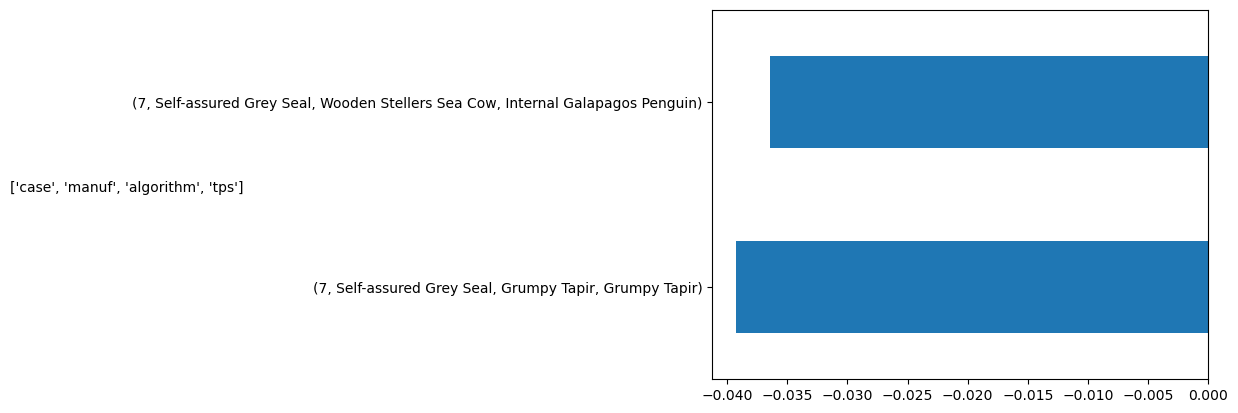

In [8]:
# MANUF, ALGORITHM, TPS 
cols = ["case","manuf","algorithm","tps","corrected_point_value"]
data_agg, below_3pc, above_3pc, results_df = aggregate(data_pp,cols, results_df)

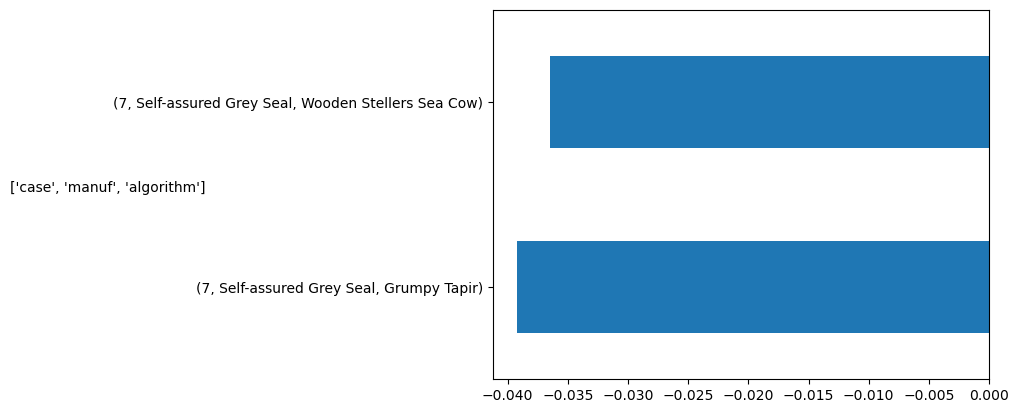

In [9]:
# MANUF, ALGO COMBINATION
cols = ["case","manuf","algorithm","corrected_point_value"]
data_agg, below_3pc, above_3pc, results_df = aggregate(data_pp,cols,results_df)

In [10]:
results_df

,case,manuf,algorithm,tps,mean_corrected_value,count,point_type
0,7,Self-assured Grey Seal,Grumpy Tapir,Grumpy Tapir,-0.039252,2,Prescription Point
1,7,Self-assured Grey Seal,Wooden Stellers Sea Cow,Internal Galapagos Penguin,-0.036451,4,Prescription Point
0,7,Self-assured Grey Seal,Grumpy Tapir,NaN,-0.039252,2,Prescription Point
1,7,Self-assured Grey Seal,Wooden Stellers Sea Cow,NaN,-0.036451,4,Prescription Point


In [11]:
# MANUF, TPS COMBO
cols = ["case","manuf","tps","corrected_point_value"]
data_agg, below_3pc, above_3pc, results_df = aggregate(data_pp,cols,results_df)

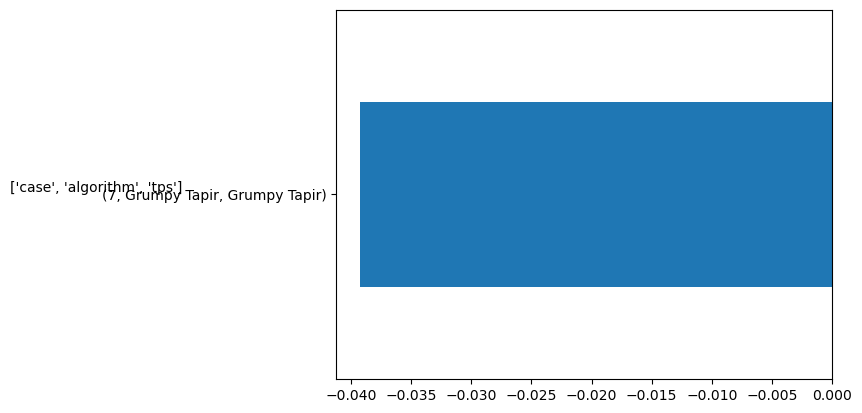

In [12]:
# ALGO, TPS COMBO
cols = ["case","algorithm","tps","corrected_point_value"]
data_agg, below_3pc, above_3pc, results_df = aggregate(data_pp,cols,results_df)

In [13]:
# MANUF 
cols = ["case","manuf","corrected_point_value"]
data_agg, below_3pc, above_3pc, results_df = aggregate(data_pp,cols,results_df)

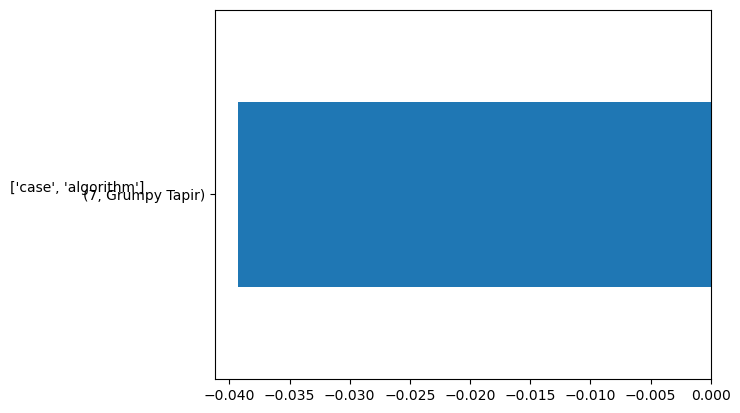

In [14]:
# ALGO
cols = ["case","algorithm","corrected_point_value"]
data_agg, below_3pc, above_3pc, results_df = aggregate(data_pp,cols,results_df)

In [15]:
# TPS
cols = ["case","tps","corrected_point_value"]
data_agg, below_3pc, above_3pc, results_df = aggregate(data_pp,cols,results_df)

In [16]:
results_df

,case,manuf,algorithm,tps,mean_corrected_value,count,point_type
0,7,Self-assured Grey Seal,Grumpy Tapir,Grumpy Tapir,-0.039252,2,Prescription Point
1,7,Self-assured Grey Seal,Wooden Stellers Sea Cow,Internal Galapagos Penguin,-0.036451,4,Prescription Point
0,7,Self-assured Grey Seal,Grumpy Tapir,NaN,-0.039252,2,Prescription Point
1,7,Self-assured Grey Seal,Wooden Stellers Sea Cow,NaN,-0.036451,4,Prescription Point
0,7,NaN,Grumpy Tapir,Grumpy Tapir,-0.039252,2,Prescription Point
0,7,NaN,Grumpy Tapir,NaN,-0.039252,2,Prescription Point


## For worst point +ve

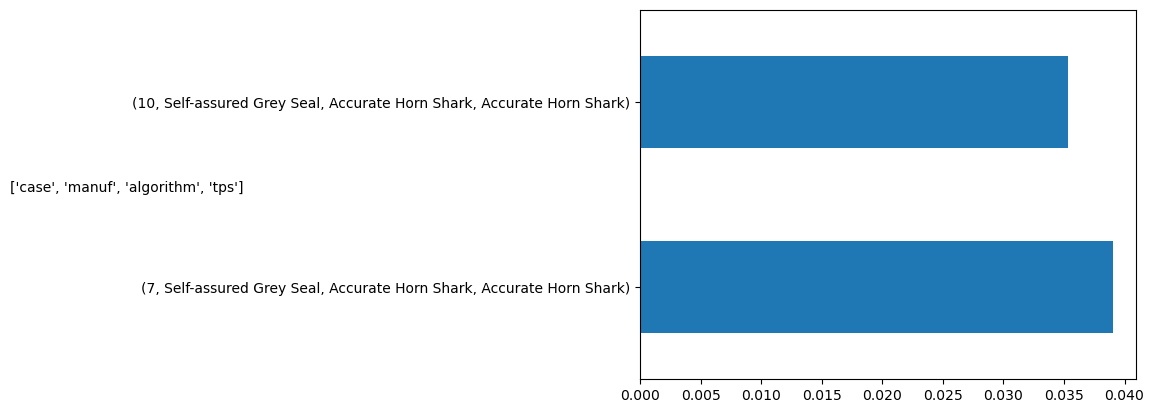

In [17]:
# MANUF, ALGORITHM, TPS 
cols = ["case","manuf","algorithm","tps","corrected_point_value"]
data_agg, below_3pc, above_3pc, results_df = aggregate(data_pos,cols,results_df)

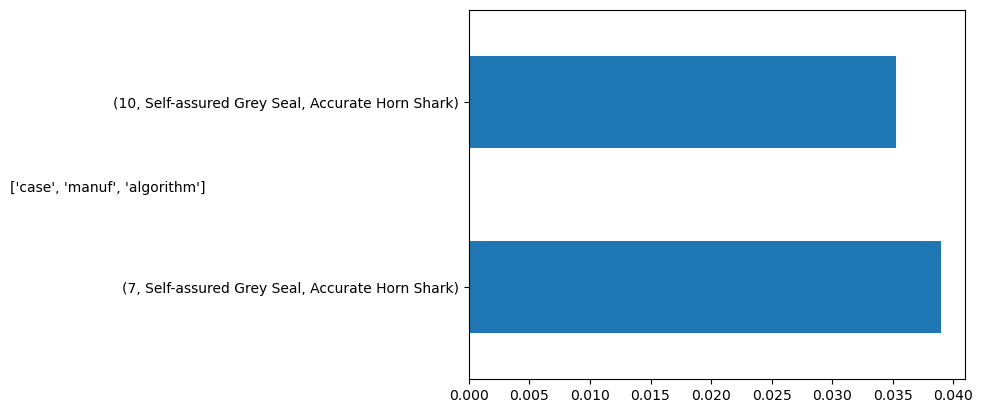

In [18]:
# MANUF, ALGORITHM COMBO
cols = ["case","manuf","algorithm","corrected_point_value"]
data_agg, below_3pc, above_3pc, results_df = aggregate(data_pos,cols,results_df)

In [19]:
# ALGORITHM, TPS 
cols = ["case","algorithm","tps","corrected_point_value"]
data_agg, below_3pc, above_3pc, results_df = aggregate(data_pos,cols,results_df)

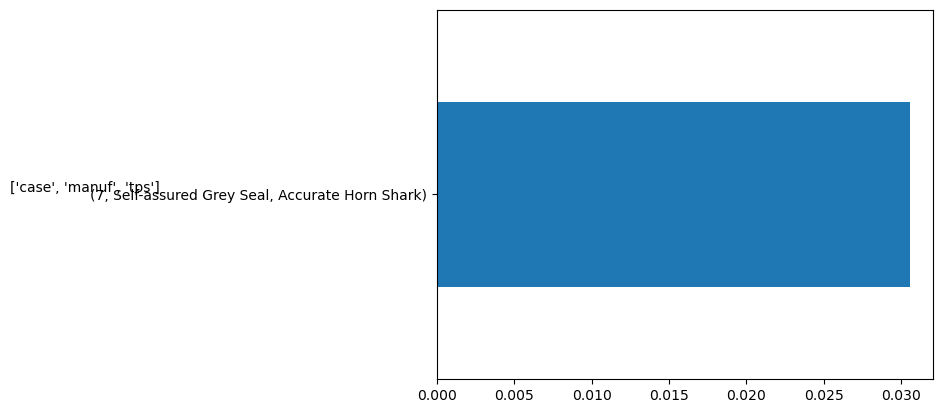

In [20]:
# MANUF, TPS 
cols = ["case","manuf","tps","corrected_point_value"]
data_agg, below_3pc, above_3pc, results_df = aggregate(data_pos,cols,results_df)

In [21]:
# MANUF
cols = ["case","manuf","corrected_point_value"]
data_agg, below_3pc, above_3pc, results_df = aggregate(data_pos,cols,results_df)

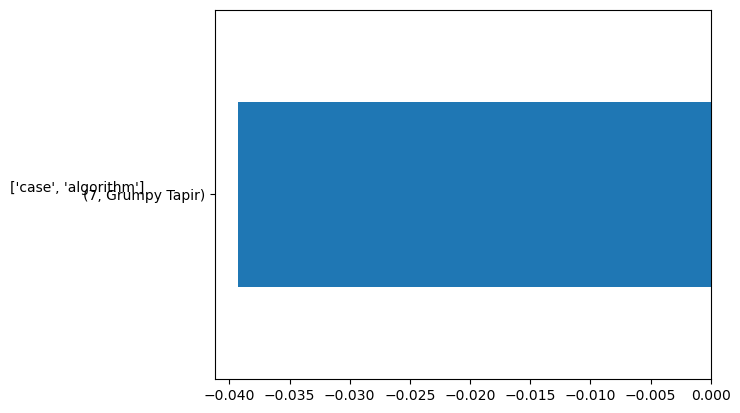

In [22]:
# ALGORITHM
cols = ["case","algorithm","corrected_point_value"]
data_agg, below_3pc, above_3pc, results_df = aggregate(data_pp,cols,results_df)

In [23]:
# TPS 
cols = ["case","tps","corrected_point_value"]
data_agg, below_3pc, above_3pc, results_df = aggregate(data_pos,cols,results_df)

In [24]:
results_df

,case,manuf,algorithm,tps,mean_corrected_value,count,point_type
0,7,Self-assured Grey Seal,Grumpy Tapir,Grumpy Tapir,-0.039252,2,Prescription Point
1,7,Self-assured Grey Seal,Wooden Stellers Sea Cow,Internal Galapagos Penguin,-0.036451,4,Prescription Point
0,7,Self-assured Grey Seal,Grumpy Tapir,NaN,-0.039252,2,Prescription Point
1,7,Self-assured Grey Seal,Wooden Stellers Sea Cow,NaN,-0.036451,4,Prescription Point
0,7,NaN,Grumpy Tapir,Grumpy Tapir,-0.039252,2,Prescription Point
0,7,NaN,Grumpy Tapir,NaN,-0.039252,2,Prescription Point
0,7,Self-assured Grey Seal,Accurate Horn Shark,Accurate Horn Shark,0.039008,2,Worst Point +ve
1,10,Self-assured Grey Seal,Accurate Horn Shark,Accurate Horn Shark,0.035290,4,Worst Point +ve
0,7,Self-assured Grey Seal,Accurate Horn Shark,NaN,0.039008,2,Worst Point +ve
1,10,Self-assured Grey Seal,Accurate Horn Shark,NaN,0.035290,4,Worst Point +ve


## For worst point -ve

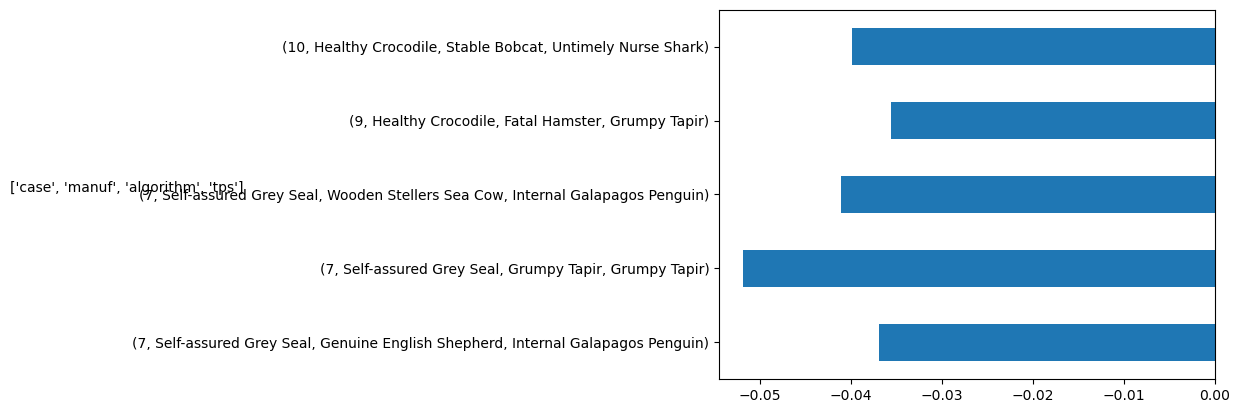

In [25]:
# MANUF, ALGORITHM, TPS 
cols = ["case","manuf","algorithm","tps","corrected_point_value"]
data_agg, below_3pc, above_3pc, results_df = aggregate(data_neg,cols,results_df)

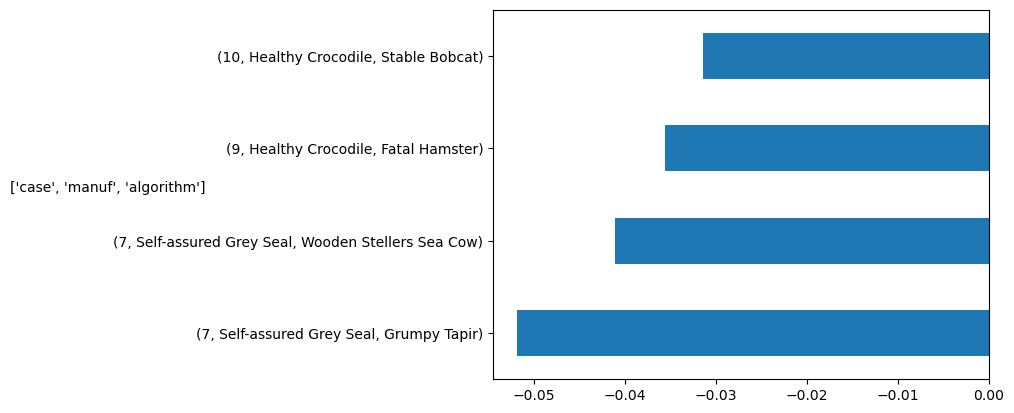

In [26]:
# MANUF, ALGORITHM
cols = ["case","manuf","algorithm","corrected_point_value"]
data_agg, below_3pc, above_3pc, results_df = aggregate(data_neg,cols,results_df)

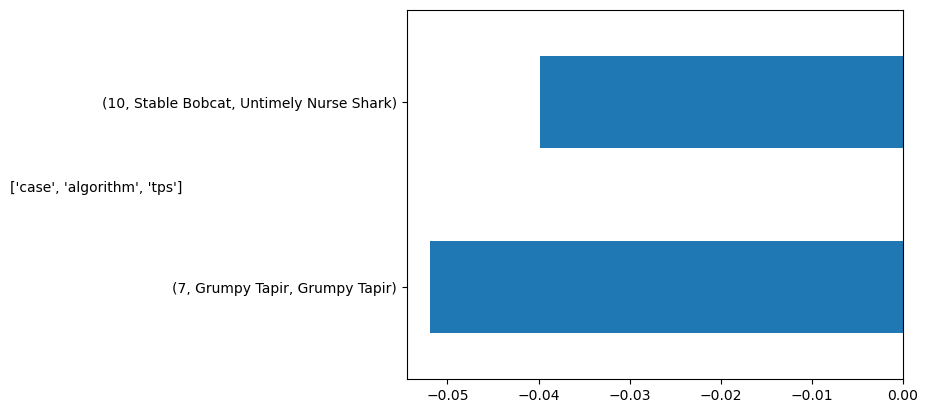

In [27]:
# ALGORITHM, TPS 
cols = ["case","algorithm","tps","corrected_point_value"]
data_agg, below_3pc, above_3pc, results_df = aggregate(data_neg,cols,results_df)

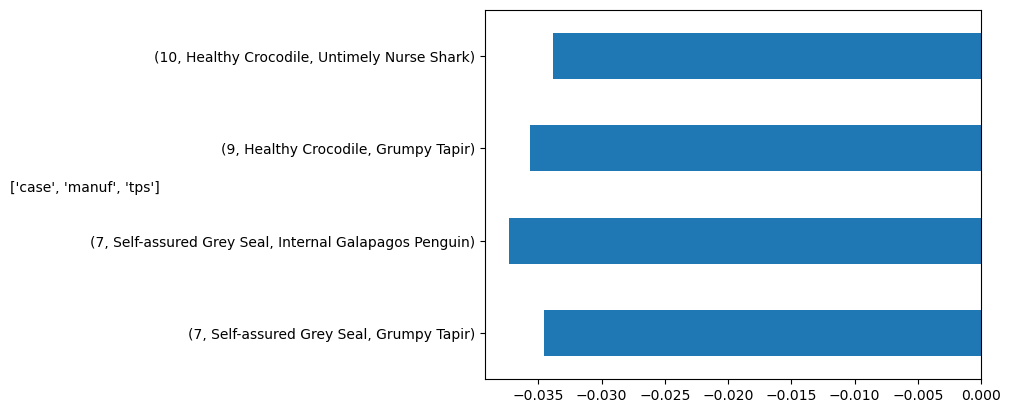

In [28]:
# MANUF, TPS 
cols = ["case","manuf","tps","corrected_point_value"]
data_agg, below_3pc, above_3pc, results_df = aggregate(data_neg,cols,results_df)

In [29]:
# MANUF
cols = ["case","manuf","corrected_point_value"]
data_agg, below_3pc, above_3pc, results_df = aggregate(data_neg,cols,results_df)

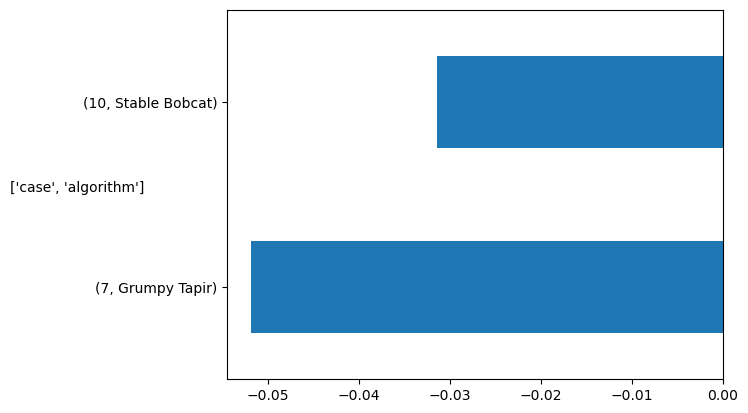

In [30]:
# ALGORITHM
cols = ["case","algorithm","corrected_point_value"]
data_agg, below_3pc, above_3pc, results_df = aggregate(data_neg,cols,results_df)

In [31]:
# TPS 
cols = ["case","tps","corrected_point_value"]
data_agg, below_3pc, above_3pc, results_df = aggregate(data_neg,cols,results_df)

In [32]:
print("\t\t\t\tDATAFRAME FOR WHICH MEAN VALUE IS MORE THAN TOLERANCE LEVEL")
results_df[['case','manuf','algorithm','tps','point_type','mean_corrected_value','count']].reset_index(drop=True).sort_values(by = 'case').fillna("ALL").style.hide(axis="index")

				DATAFRAME FOR WHICH MEAN VALUE IS MORE THAN TOLERANCE LEVEL


case,manuf,algorithm,tps,point_type,mean_corrected_value,count
7,Self-assured Grey Seal,Grumpy Tapir,Grumpy Tapir,Prescription Point,-0.039252,2
7,Self-assured Grey Seal,ALL,Internal Galapagos Penguin,Worst Point -ve,-0.037334,41
7,Self-assured Grey Seal,ALL,Grumpy Tapir,Worst Point -ve,-0.034521,7
7,ALL,Grumpy Tapir,Grumpy Tapir,Worst Point -ve,-0.051899,2
7,Self-assured Grey Seal,Wooden Stellers Sea Cow,ALL,Worst Point -ve,-0.041101,4
7,Self-assured Grey Seal,Grumpy Tapir,ALL,Worst Point -ve,-0.051899,2
7,ALL,Grumpy Tapir,ALL,Worst Point -ve,-0.051899,2
7,Self-assured Grey Seal,Grumpy Tapir,Grumpy Tapir,Worst Point -ve,-0.051899,2
7,Self-assured Grey Seal,Genuine English Shepherd,Internal Galapagos Penguin,Worst Point -ve,-0.036927,37
7,ALL,Grumpy Tapir,ALL,Prescription Point,-0.039252,2
